# Further analysis of the gut uLIPSTIC dataset: focusing on the CD4 subset

In [1]:
!(python --version)

Python 3.9.2


In [2]:
from helper_functions import *
from pandas.api.types import CategoricalDtype
from plotnine import * 
from scipy.cluster.hierarchy import dendrogram,linkage, set_link_color_palette
from scipy.stats import gmean, mannwhitneyu

import matplotlib as mpl
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns

sc.set_figure_params(figsize=(5,5), vector_friendly=False)

In [3]:
ad  = sc.read_h5ad("iel_tcr_feb21.h5ad")

In [4]:
ad.obsm["X_umap_full"] = ad.obsm["X_umap"].copy()

In [5]:
## cluster 19 is similar to CD4 T cell clusters 8 and 9 (based on the dendrogram, in supplement), include it for now
ad = ad[(ad.obs.annotation == "CD4") | (ad.obs.leiden == "19")] 
ad.shape

(944, 14332)

## build new neighborhood graph just on CD4 T cells

In [6]:
ad.X = ad.layers["pearson_theta_1"].copy()

In [7]:
sc.pp.neighbors(ad, n_neighbors=30, n_pcs=40, use_rep='X_pca',)
sc.tl.leiden(ad, resolution=1.3)
sc.tl.umap(ad)

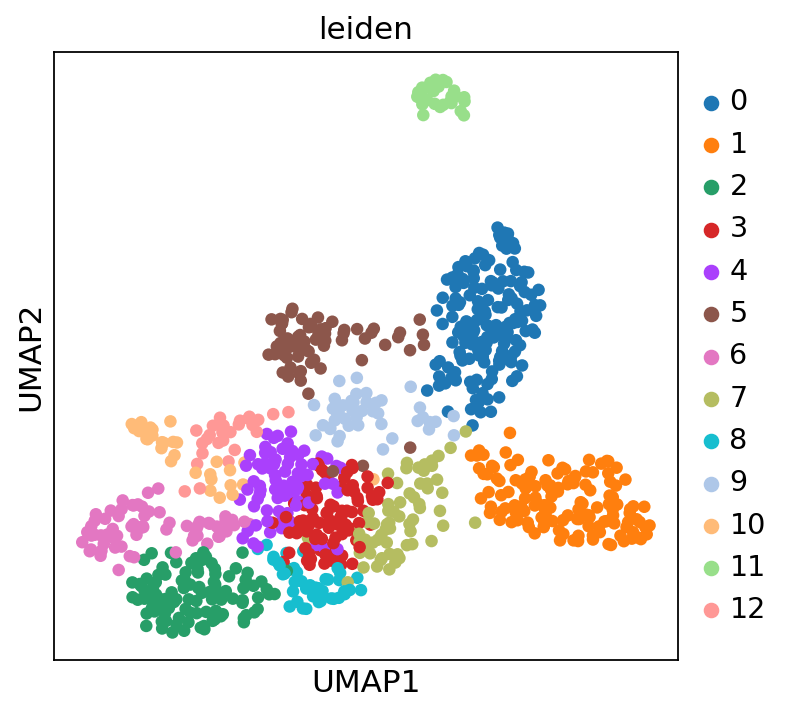

In [8]:
sc.pl.umap(ad, color = "leiden")

## plot on original UMAP

In [9]:
ad.obsm["X_umap_cd4"] = ad.obsm["X_umap"].copy()
ad.obsm["X_umap"] = ad.obsm["X_umap_full"].copy()

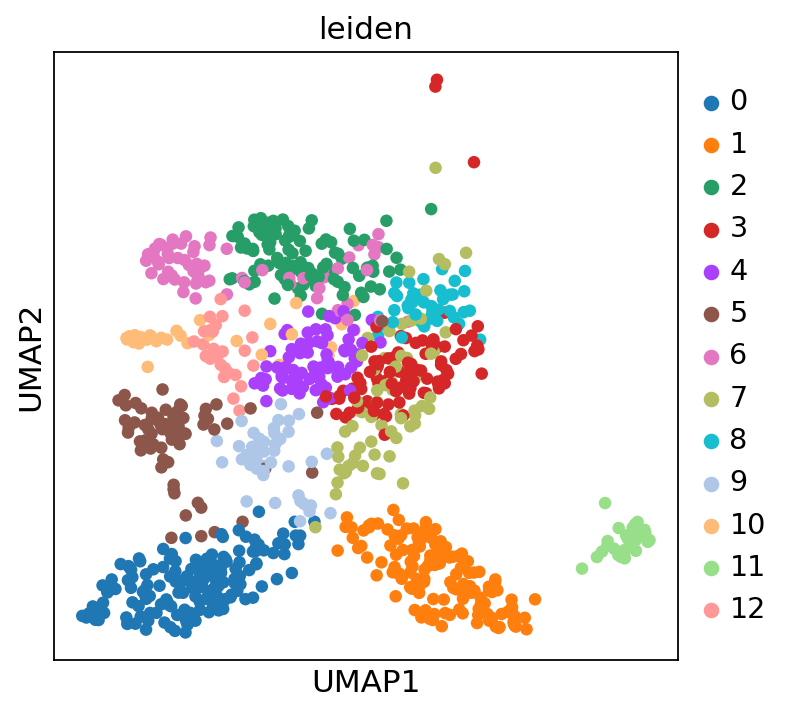

In [10]:
sc.pl.umap(ad, color = "leiden")

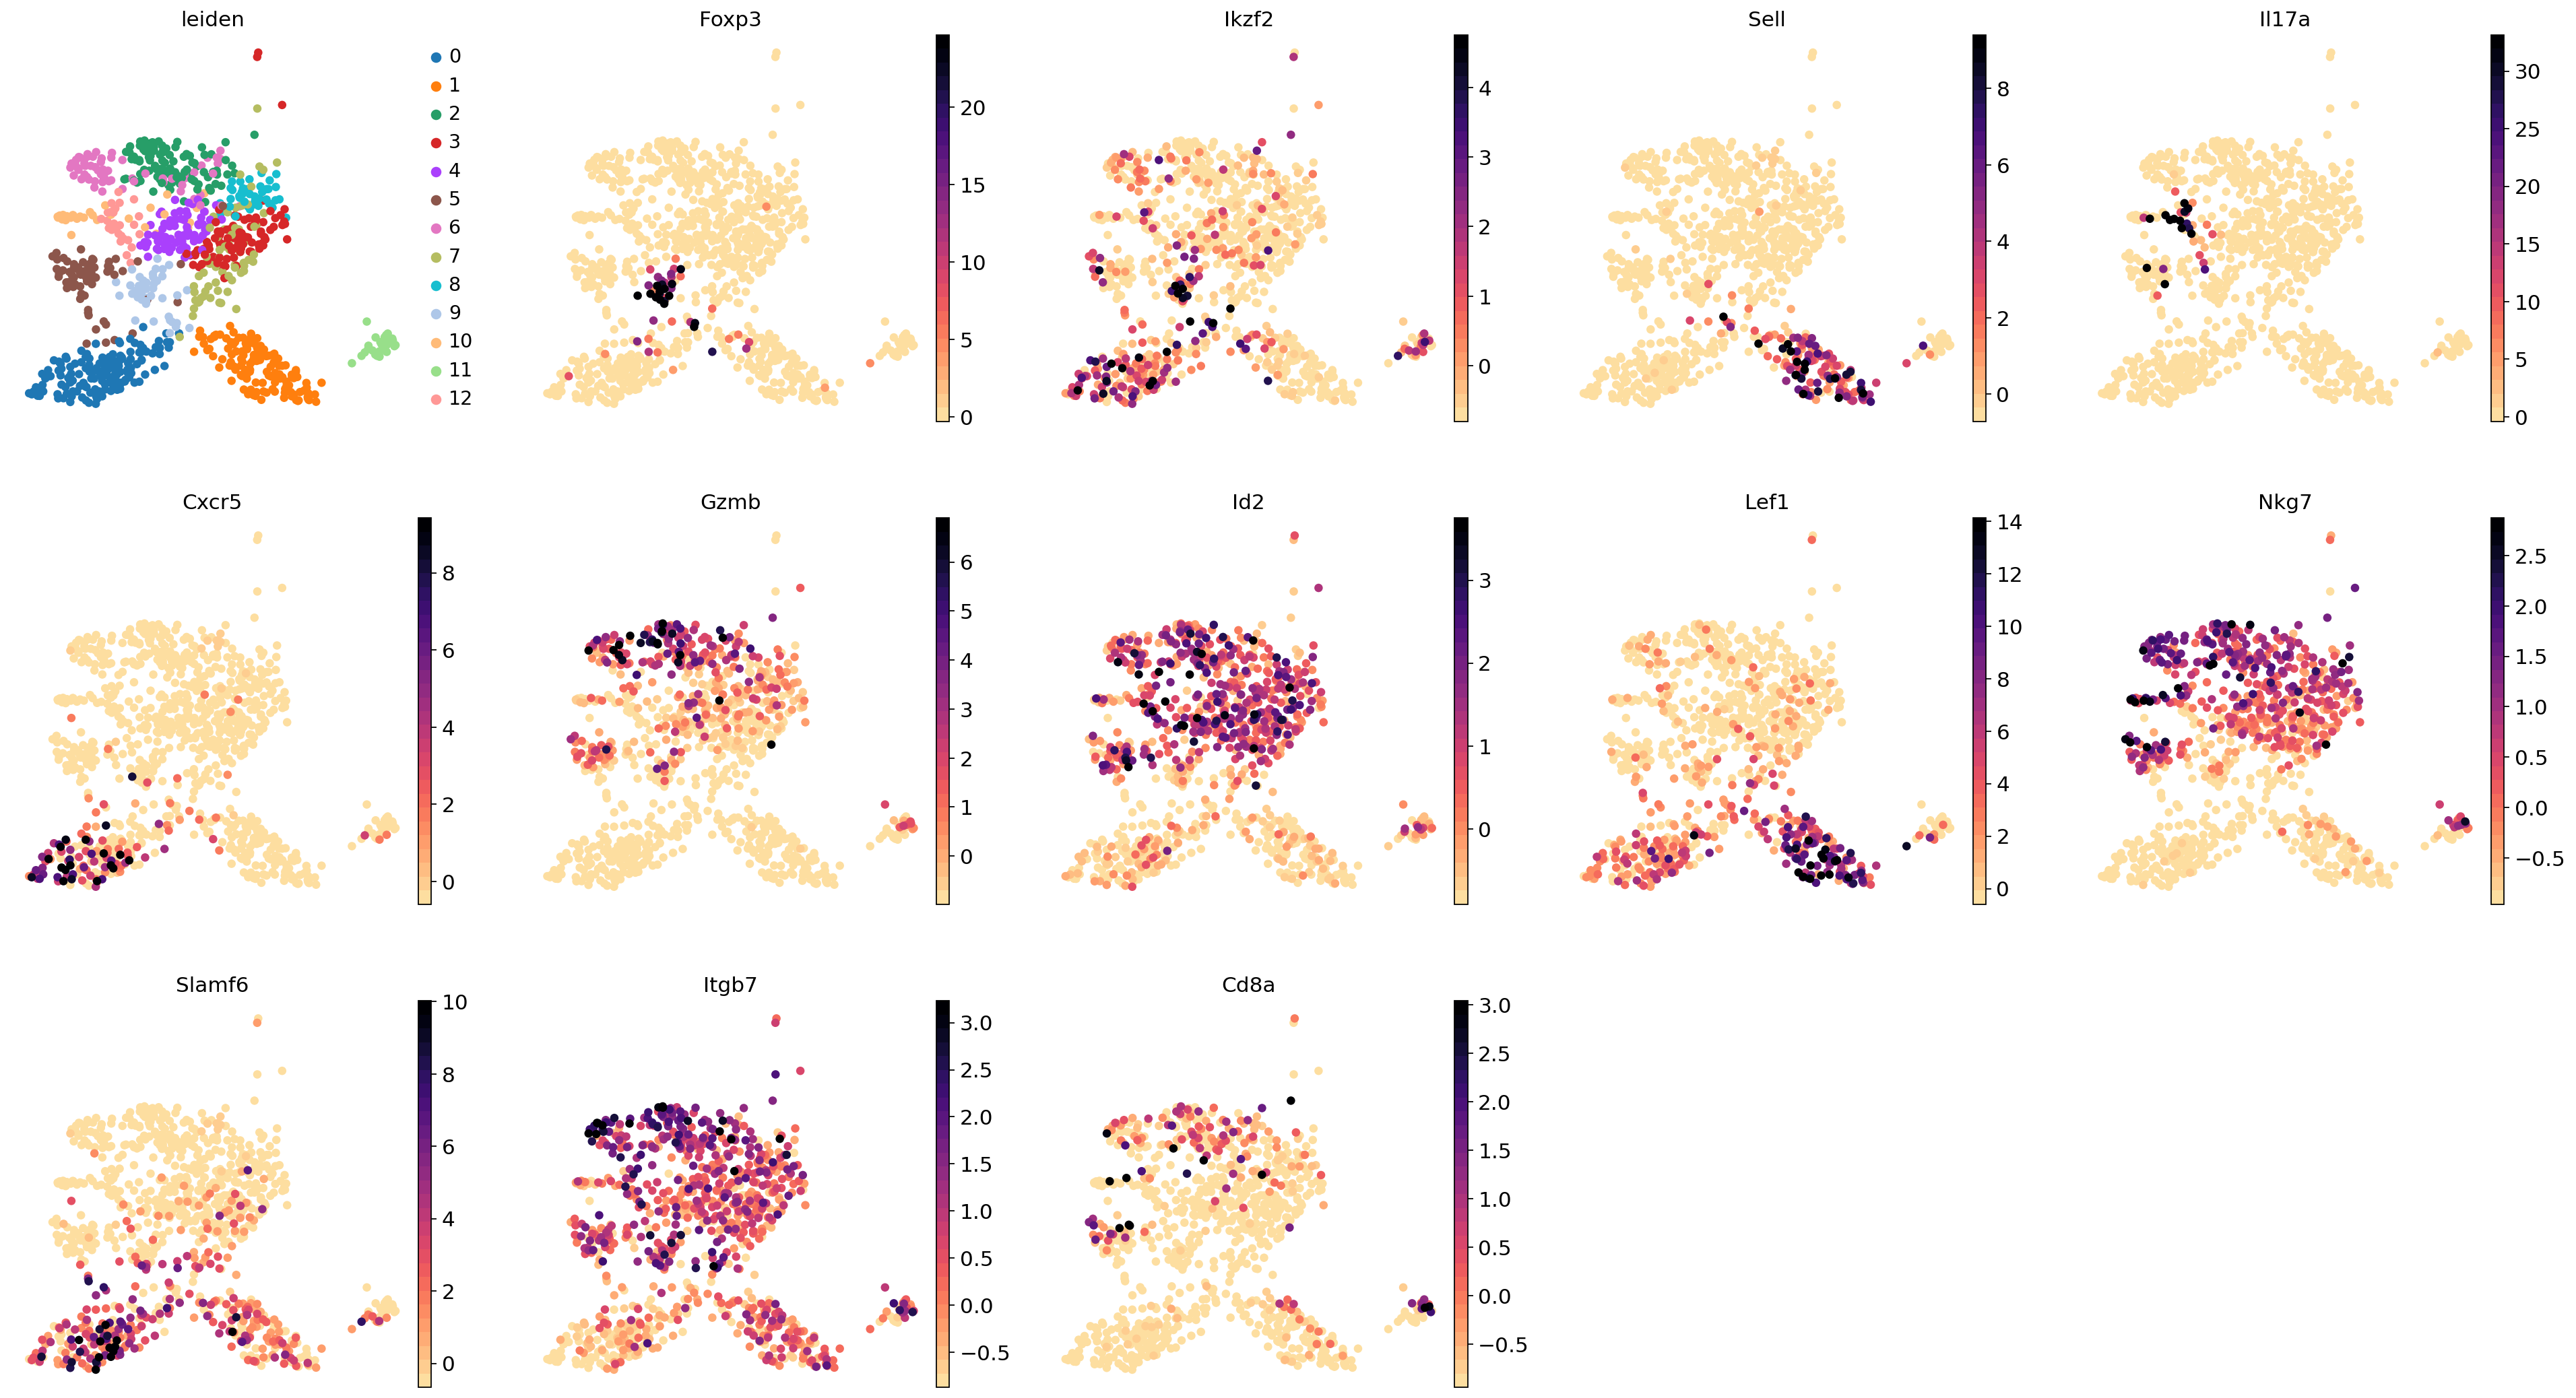

In [11]:
## GEX figure for supplement, should include all clusters
sc.settings.figdir="paper_figures/supplemental/cd4/"
sc.pl.umap(ad, frameon = False,  vmin="p1", vmax="p99", cmap=magma_cmap, ncols=5, color = [
    "leiden", "Foxp3", "Ikzf2", "Sell",  "Il17a", "Cxcr5", "Gzmb", "Id2", "Lef1", "Nkg7", "Slamf6", "Itgb7", "Cd8a"]) 

##  annotate these clusters

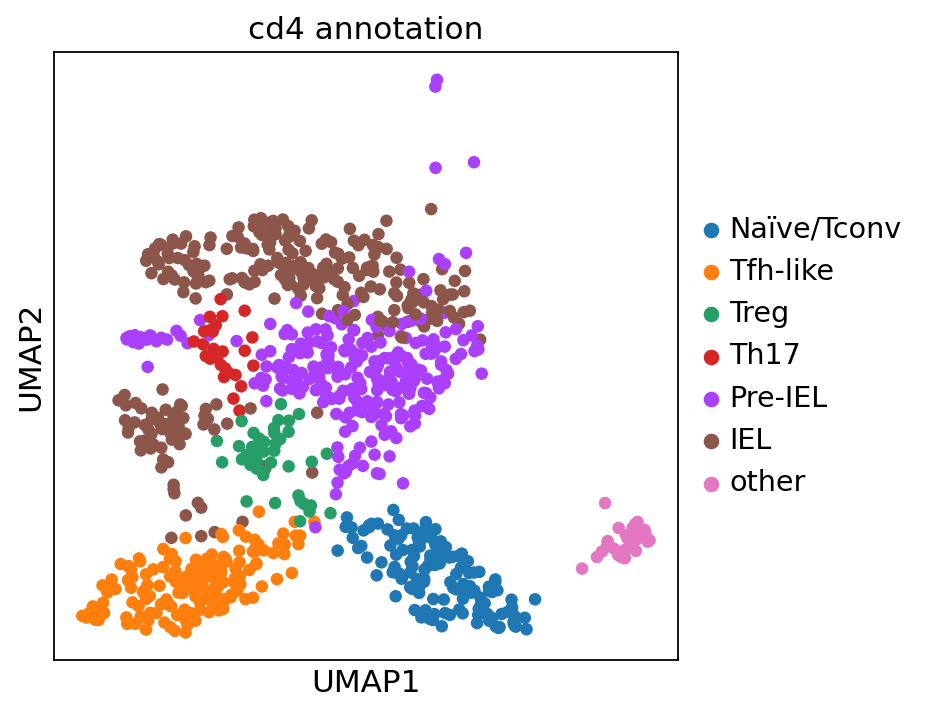

In [12]:

from pandas.api.types import CategoricalDtype

## IEL, for top, and that other one,
## pre-IEL for ones on the right, including the knob thing
## conventional for the 2 bottom ones (naïve-like, Tfh-like )
## tregs
def annotate(cl) :
    c = int(cl)
    if c == 0:
        return "Tfh-like"
    elif c == 1:
        return "Naïve/Tconv"
    elif c == 9:
        return "Treg"
    elif c == 12:
        return "Th17"
    elif c in [5, 6, 2, 8]:
        return "IEL"
    elif c  == 11:
        return "other"
    return "Pre-IEL"
ad.obs["cd4 annotation"] = [annotate(cl) for cl in ad.obs.leiden]
ad.obs["cd4 annotation"] = ad.obs["cd4 annotation"].astype(CategoricalDtype(
    categories=["Naïve/Tconv", "Tfh-like", "Treg", "Th17", "Pre-IEL", "IEL", "other"], ordered = True))
sc.pl.umap(ad, color="cd4 annotation")

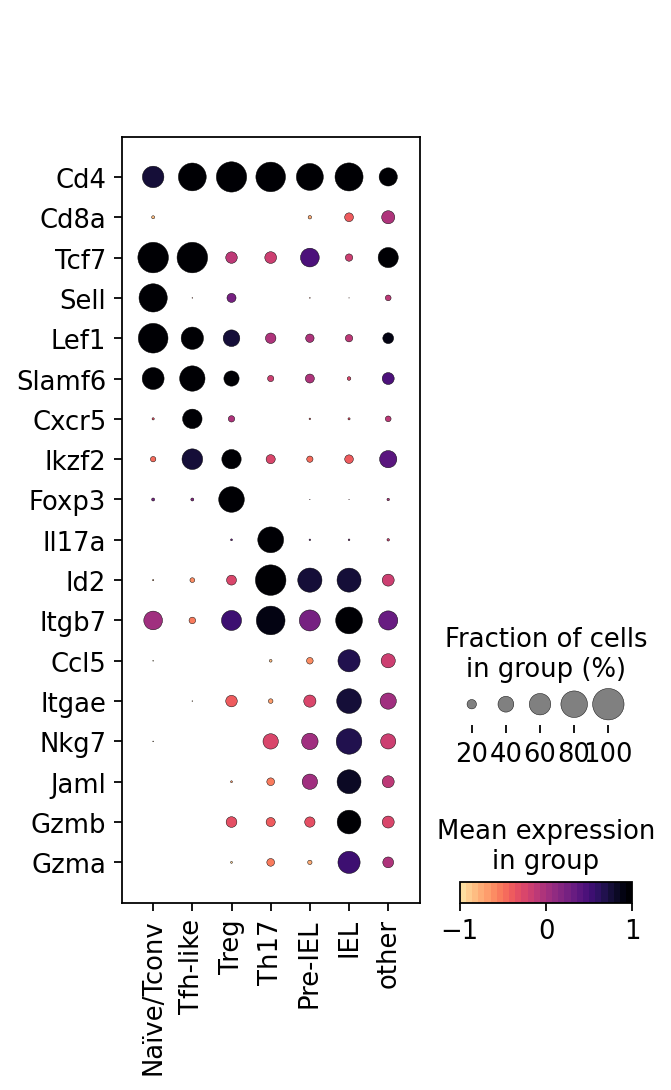

In [13]:
sc.pl.dotplot(ad, swap_axes=True, groupby="cd4 annotation", norm = mpl.colors.Normalize(vmin=-1, vmax=1), 
              cmap=magma_cmap,  var_names = [
                  "Cd4", "Cd8a", "Tcf7", "Sell", "Lef1", "Slamf6", "Cxcr5", "Ikzf2", "Foxp3", "Il17a", "Id2",
                  "Itgb7", "Ccl5", "Itgae", "Nkg7", "Jaml", "Gzmb", "Gzma"])

## remove the weird "Other" cluster, still not sure what it is


In [14]:
ad = ad[ad.obs["cd4 annotation"] != "other"].copy()

/Genomics/grid/users/skwalker/new_scvi/lib/python3.9/site-packages/anndata/compat/__init__.py:263: FutureWarning: During AnnData slicing, found matrix at .uns['clone_id']['distances'] that happens to be dimensioned at n_obs×n_obs (944×944).

These matrices should now be stored in the .obsp attribute.
This slicing behavior will be removed in anndata 0.8.


## <font color = "purple"> Supplemental figure, 11B

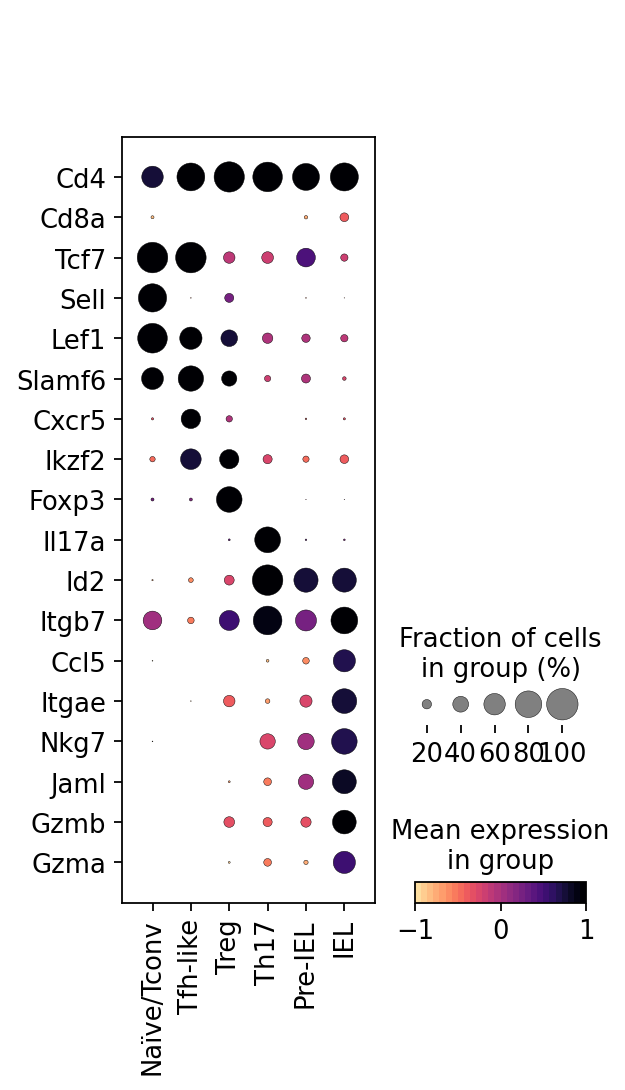

In [15]:
sc.settings.figdir="paper_figures/supplemental/cd4/"
sc.pl.dotplot(ad, swap_axes=True, groupby="cd4 annotation", norm = mpl.colors.Normalize(vmin=-1, vmax=1), 
              cmap=magma_cmap,  save="cd4_gex.pdf", var_names = [
                  "Cd4", "Cd8a", "Tcf7", "Sell", "Lef1", "Slamf6", "Cxcr5", "Ikzf2", "Foxp3", "Il17a", "Id2",
                  "Itgb7", "Ccl5", "Itgae", "Nkg7", "Jaml", "Gzmb", "Gzma"])

## rename CD4 clusters

In [16]:
ad.obs["cd4 cluster"] = ["cd4_" + cl if cl != "12" else "cd4_11" for cl in ad.obs["leiden"]]

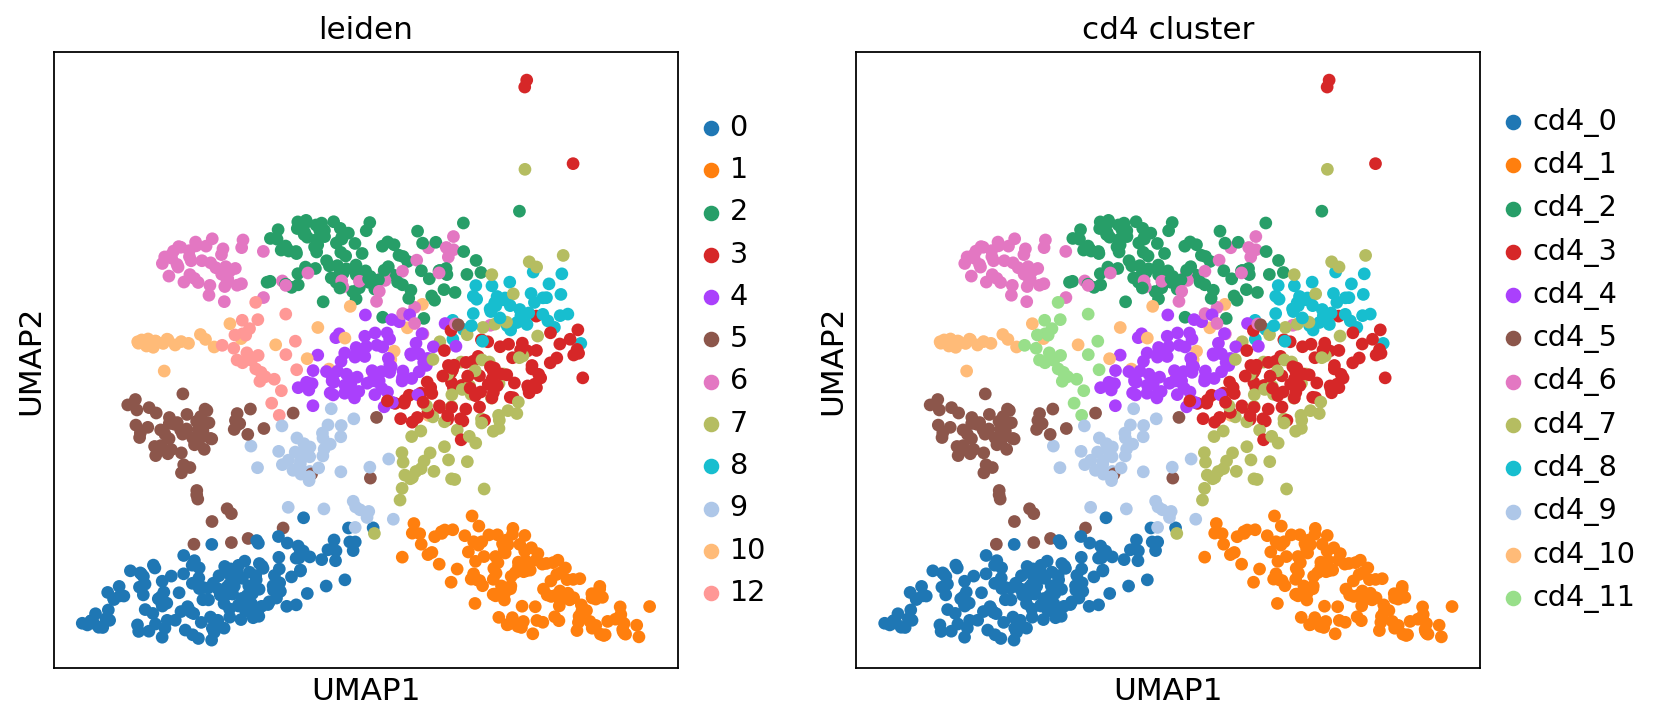

In [17]:
sc.pl.umap(ad, color = ["leiden", "cd4 cluster"])

## <font color = "purple"> supplemental figure, 11A

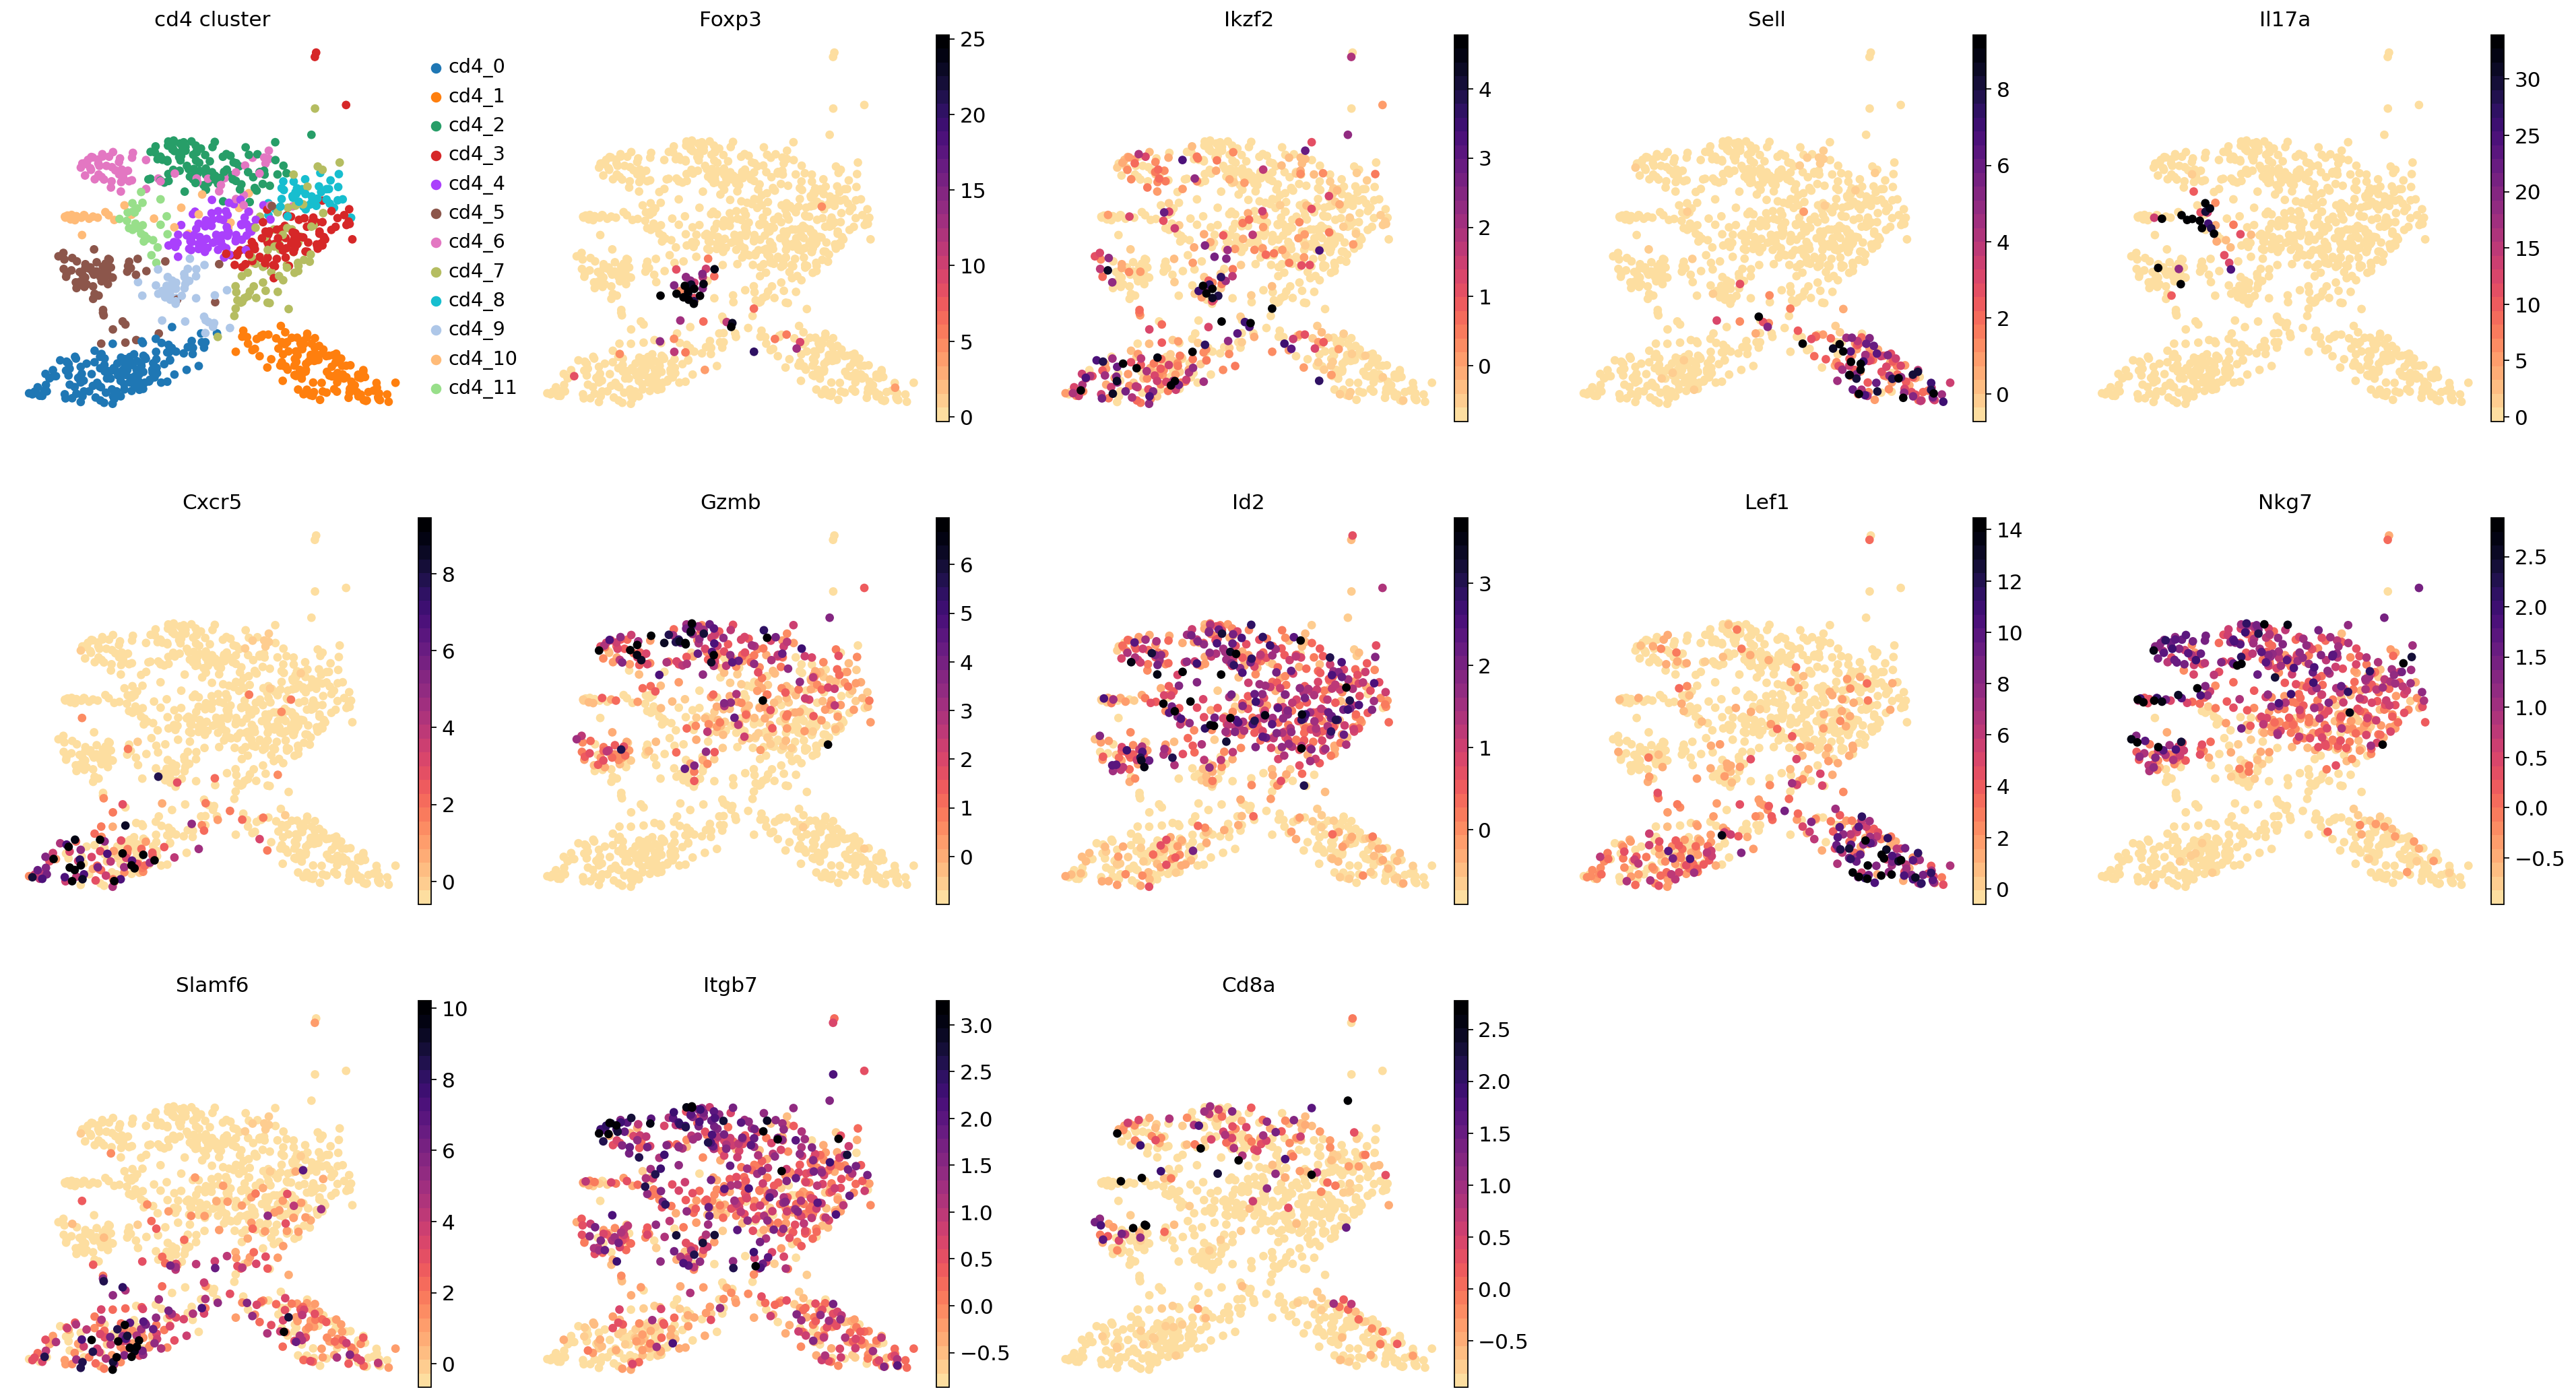

In [18]:
## GEX figure for supplement, should include all clusters
sc.settings.figdir="paper_figures/supplemental/cd4/"
sc.pl.umap(ad, frameon = False,  vmin="p1", vmax="p99", cmap=magma_cmap, ncols=5, color = [
    "cd4 cluster", "Foxp3", "Ikzf2", "Sell",  "Il17a", "Cxcr5", "Gzmb", "Id2", "Lef1", "Nkg7", "Slamf6", "Itgb7",
    "Cd8a"], save = "_gex.pdf") 

## <font color = "purple"> supplemental figure, 11C

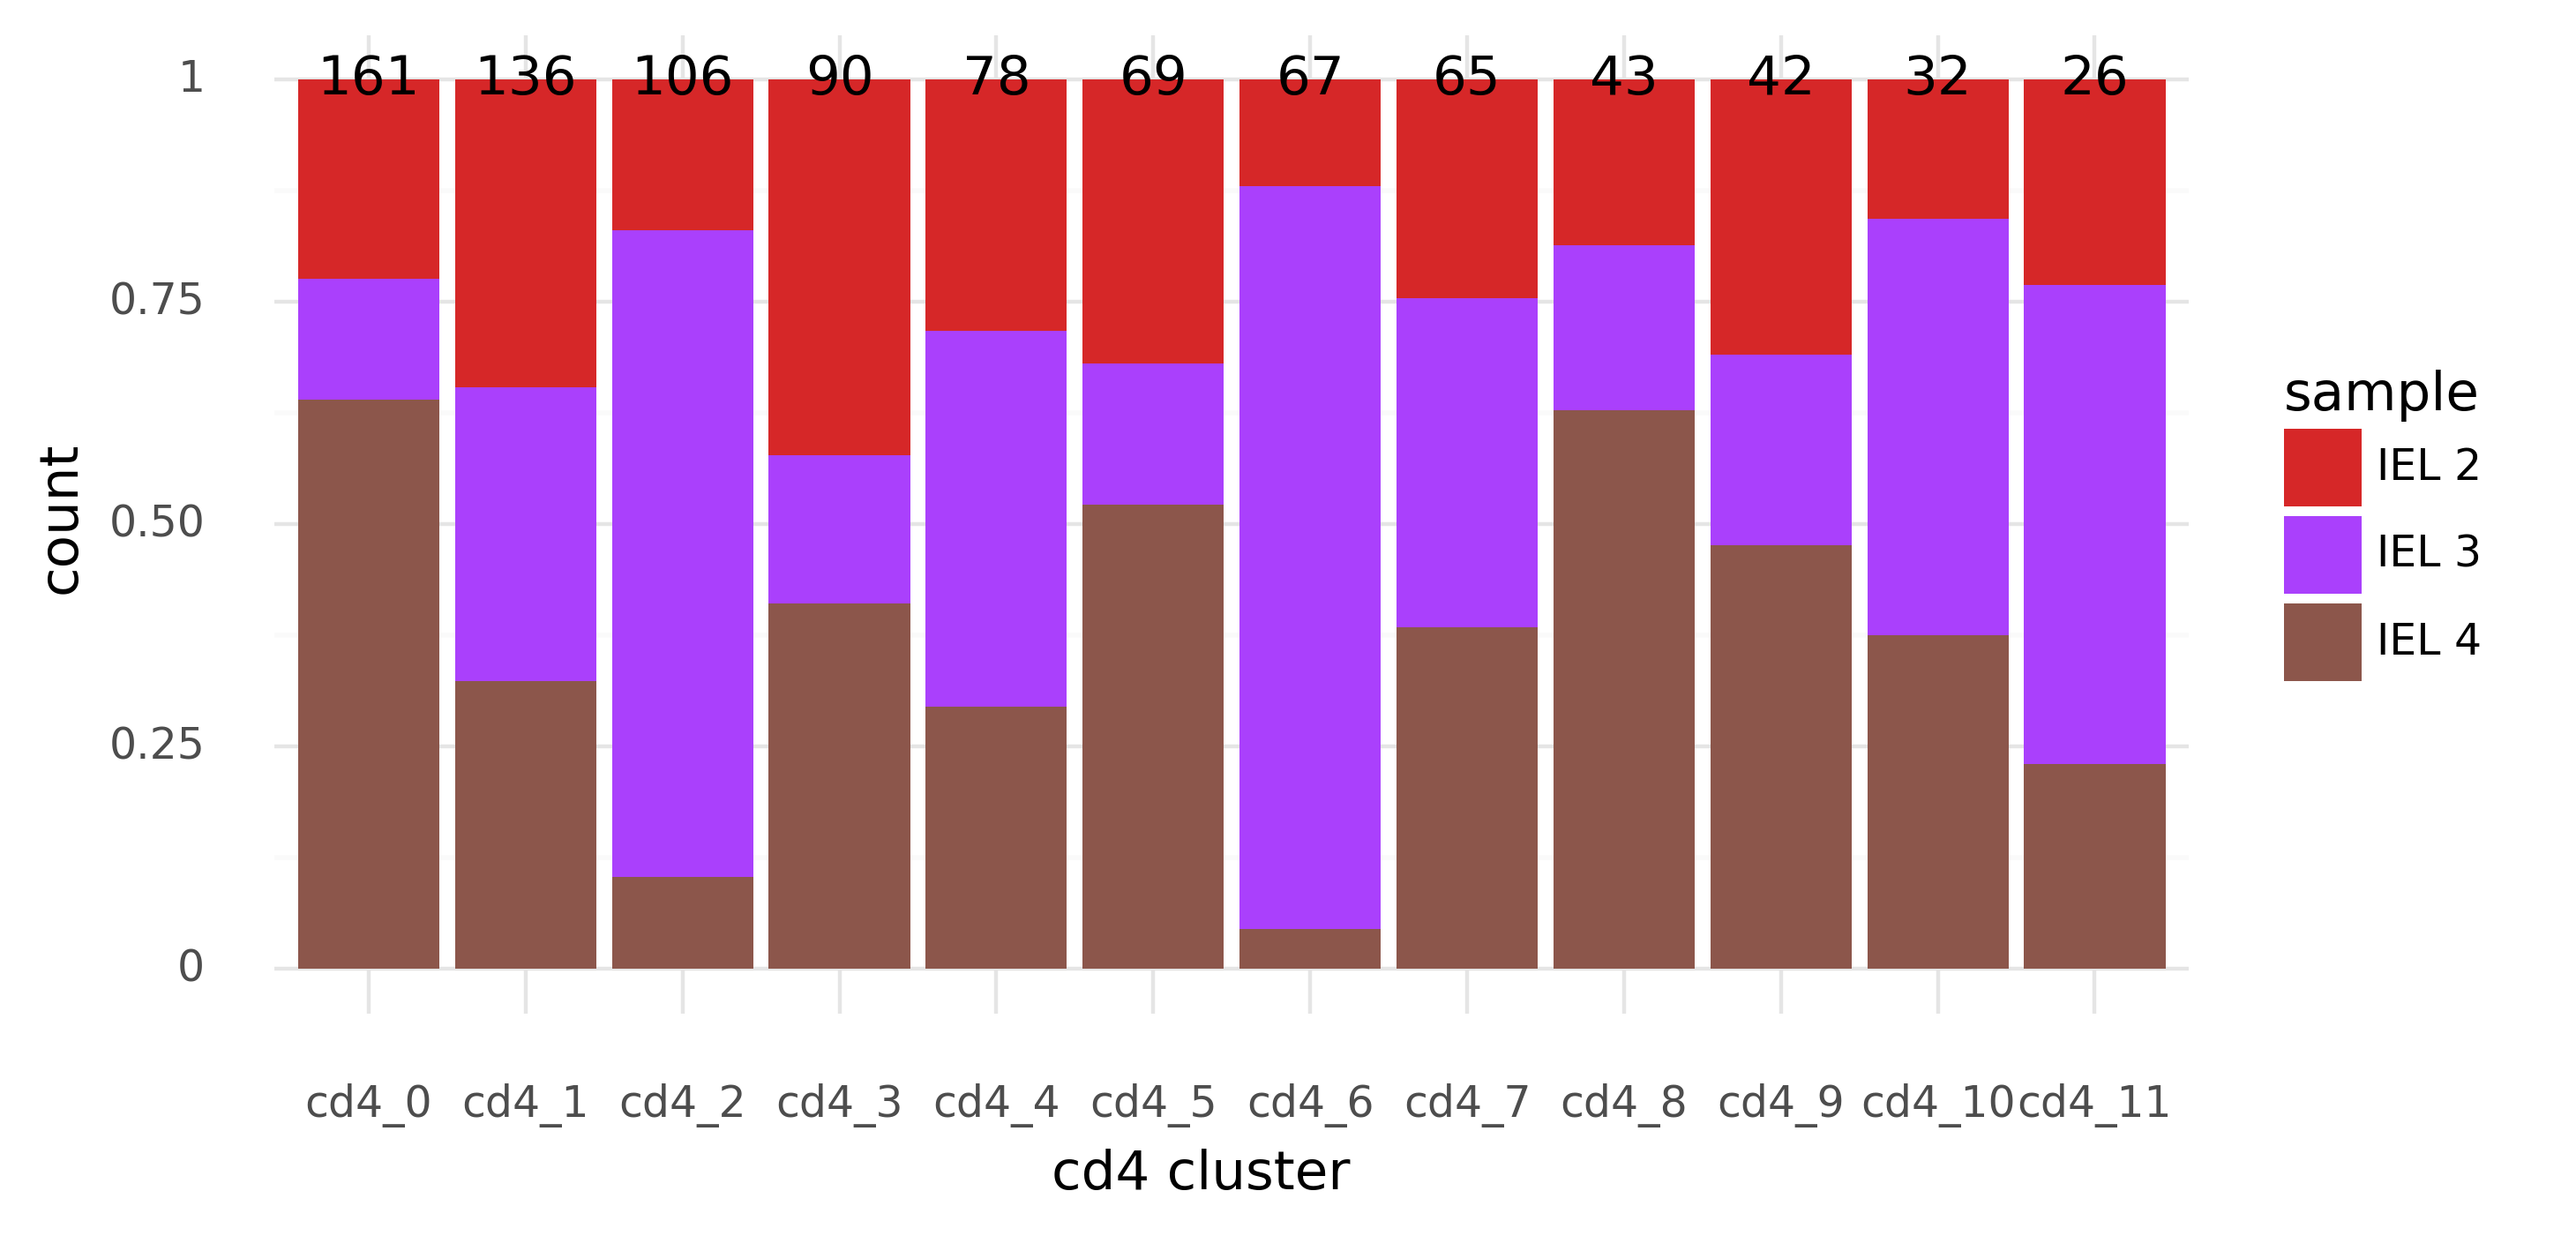

<ggplot: (8791782394432)>

In [19]:
samp_plot = ggplot(ad.obs, aes(x="cd4 cluster", fill = "sample")) + geom_bar(position = "fill") + theme_minimal(
) + theme(dpi=200, figure_size=(7, 3.6)) + scale_fill_manual(ad.uns["sample_colors"]) + geom_text(ad.obs.groupby(
"cd4 cluster").count()[["sample"]].reset_index(), aes(x="cd4 cluster", label="sample"), color="black", y=1, 
                                                                                                inherit_aes=False)
samp_plot

In [20]:
ggsave(samp_plot, "paper_figures/supplemental/cd4/cluster_samp_composition.pdf")

/Genomics/grid/users/skwalker/new_scvi/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 7 x 3.6 in image.
/Genomics/grid/users/skwalker/new_scvi/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: paper_figures/supplemental/cd4/cluster_samp_composition.pdf


/Genomics/grid/users/skwalker/new_scvi/lib/python3.9/site-packages/plotnine/layer.py:334: PlotnineWarning: stat_density : Removed 65 rows containing non-finite values.


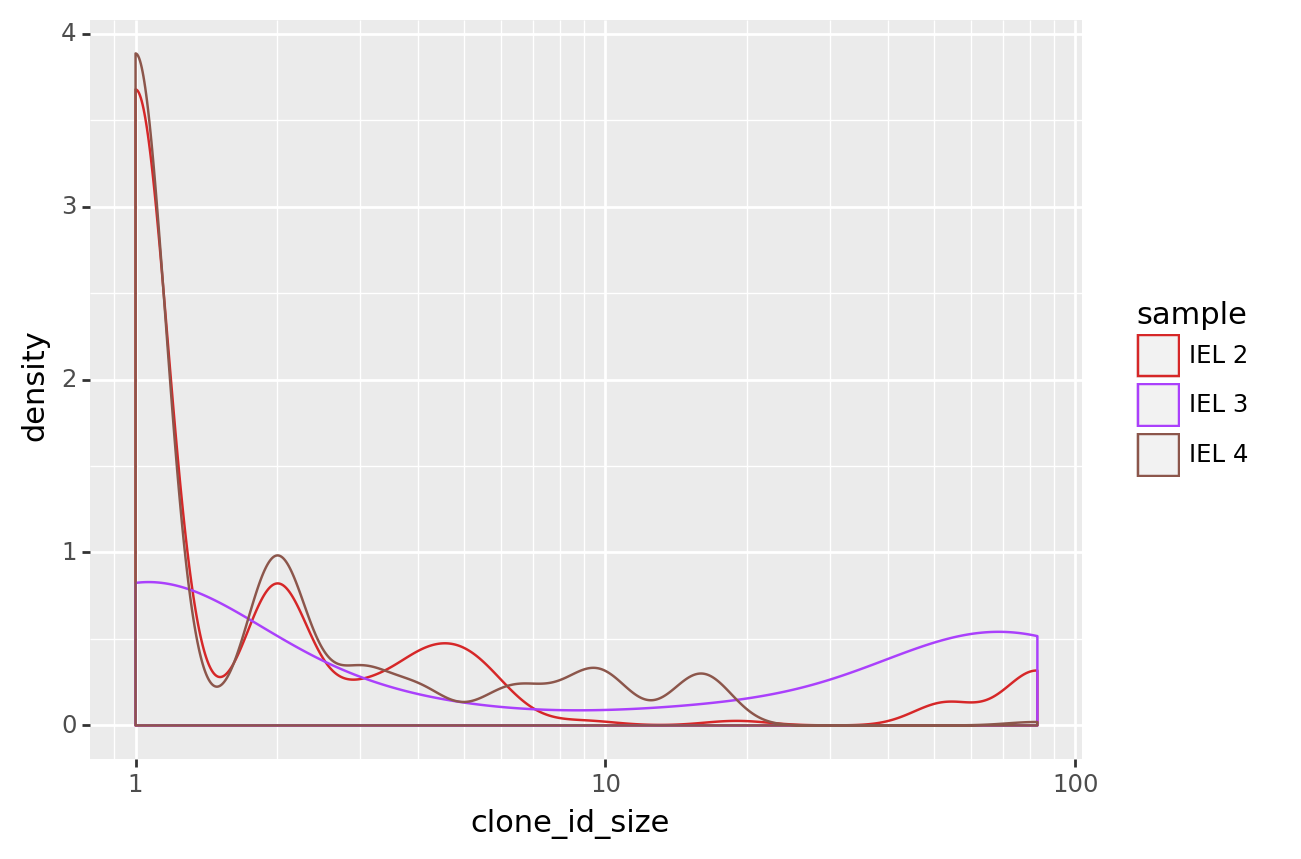

<ggplot: (8791782398257)>

In [21]:
ggplot(ad.obs, aes(x="clone_id_size", color = "sample")) + geom_density() + scale_color_manual(
    ad.uns["sample_colors"]) + scale_x_log10()

In [22]:
cd4_annot_lfcs = new_lfcs(ad,  "raw_counts", "pearson_theta_1", cl_level =  "cd4 annotation", 
                           pseudocount_threshold=0.1)

num genes with no counts in raw matrix: 926
(13406,)
0.1
(915, 13406)
(1, 13406)
0.0043715848587453365
IEL


/Genomics/grid/users/skwalker/new_scvi/lib/python3.9/site-packages/anndata/compat/__init__.py:263: FutureWarning: During AnnData slicing, found matrix at .uns['clone_id']['distances'] that happens to be dimensioned at n_obs×n_obs (915×915).

These matrices should now be stored in the .obsp attribute.
This slicing behavior will be removed in anndata 0.8.
/Genomics/grid/users/skwalker/new_scvi/lib/python3.9/site-packages/scipy/stats/_stats_py.py:279: RuntimeWarning: divide by zero encountered in log
/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:29: RuntimeWarning: invalid value encountered in true_divide
/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:29: RuntimeWarning: divide by zero encountered in true_divide


  results: log2FC > 0.5: 301 genes; log2FC < -0.5: 642 genes
Naïve/Tconv


/Genomics/grid/users/skwalker/new_scvi/lib/python3.9/site-packages/anndata/compat/__init__.py:263: FutureWarning: During AnnData slicing, found matrix at .uns['clone_id']['distances'] that happens to be dimensioned at n_obs×n_obs (915×915).

These matrices should now be stored in the .obsp attribute.
This slicing behavior will be removed in anndata 0.8.
/Genomics/grid/users/skwalker/new_scvi/lib/python3.9/site-packages/scipy/stats/_stats_py.py:279: RuntimeWarning: divide by zero encountered in log
/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:29: RuntimeWarning: divide by zero encountered in true_divide
/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:29: RuntimeWarning: invalid value encountered in true_divide


  results: log2FC > 0.5: 574 genes; log2FC < -0.5: 581 genes
Pre-IEL


/Genomics/grid/users/skwalker/new_scvi/lib/python3.9/site-packages/anndata/compat/__init__.py:263: FutureWarning: During AnnData slicing, found matrix at .uns['clone_id']['distances'] that happens to be dimensioned at n_obs×n_obs (915×915).

These matrices should now be stored in the .obsp attribute.
This slicing behavior will be removed in anndata 0.8.


  results: log2FC > 0.5: 73 genes; log2FC < -0.5: 308 genes
Tfh-like


/Genomics/grid/users/skwalker/new_scvi/lib/python3.9/site-packages/anndata/compat/__init__.py:263: FutureWarning: During AnnData slicing, found matrix at .uns['clone_id']['distances'] that happens to be dimensioned at n_obs×n_obs (915×915).

These matrices should now be stored in the .obsp attribute.
This slicing behavior will be removed in anndata 0.8.
/Genomics/grid/users/skwalker/new_scvi/lib/python3.9/site-packages/scipy/stats/_stats_py.py:279: RuntimeWarning: divide by zero encountered in log
/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:29: RuntimeWarning: divide by zero encountered in true_divide
/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:29: RuntimeWarning: invalid value encountered in true_divide


  results: log2FC > 0.5: 874 genes; log2FC < -0.5: 403 genes
Th17


/Genomics/grid/users/skwalker/new_scvi/lib/python3.9/site-packages/anndata/compat/__init__.py:263: FutureWarning: During AnnData slicing, found matrix at .uns['clone_id']['distances'] that happens to be dimensioned at n_obs×n_obs (915×915).

These matrices should now be stored in the .obsp attribute.
This slicing behavior will be removed in anndata 0.8.
/Genomics/grid/users/skwalker/new_scvi/lib/python3.9/site-packages/scipy/stats/_stats_py.py:279: RuntimeWarning: divide by zero encountered in log
/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:29: RuntimeWarning: invalid value encountered in true_divide
/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:29: RuntimeWarning: divide by zero encountered in true_divide


  results: log2FC > 0.5: 56 genes; log2FC < -0.5: 48 genes
Treg


/Genomics/grid/users/skwalker/new_scvi/lib/python3.9/site-packages/anndata/compat/__init__.py:263: FutureWarning: During AnnData slicing, found matrix at .uns['clone_id']['distances'] that happens to be dimensioned at n_obs×n_obs (915×915).

These matrices should now be stored in the .obsp attribute.
This slicing behavior will be removed in anndata 0.8.
/Genomics/grid/users/skwalker/new_scvi/lib/python3.9/site-packages/scipy/stats/_stats_py.py:279: RuntimeWarning: divide by zero encountered in log
/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:29: RuntimeWarning: divide by zero encountered in true_divide
/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:29: RuntimeWarning: invalid value encountered in true_divide


  results: log2FC > 0.5: 651 genes; log2FC < -0.5: 38 genes


In [24]:
write_lfc_spreadsheet(cd4_annot_lfcs, "supplementary_tables/CD4_annotation_LFCs.xls", sort_column = "log2FC")

/Genomics/pritykinlab/sarah/lipstic_analysis/ulipstic-analysis/helper_functions.py:103: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.


## <font color="navy"> main figure 4D

In [25]:
ad.obs[" cd4 annotation "] = ad.obs["cd4 annotation"].str.replace(": ", ":\n")

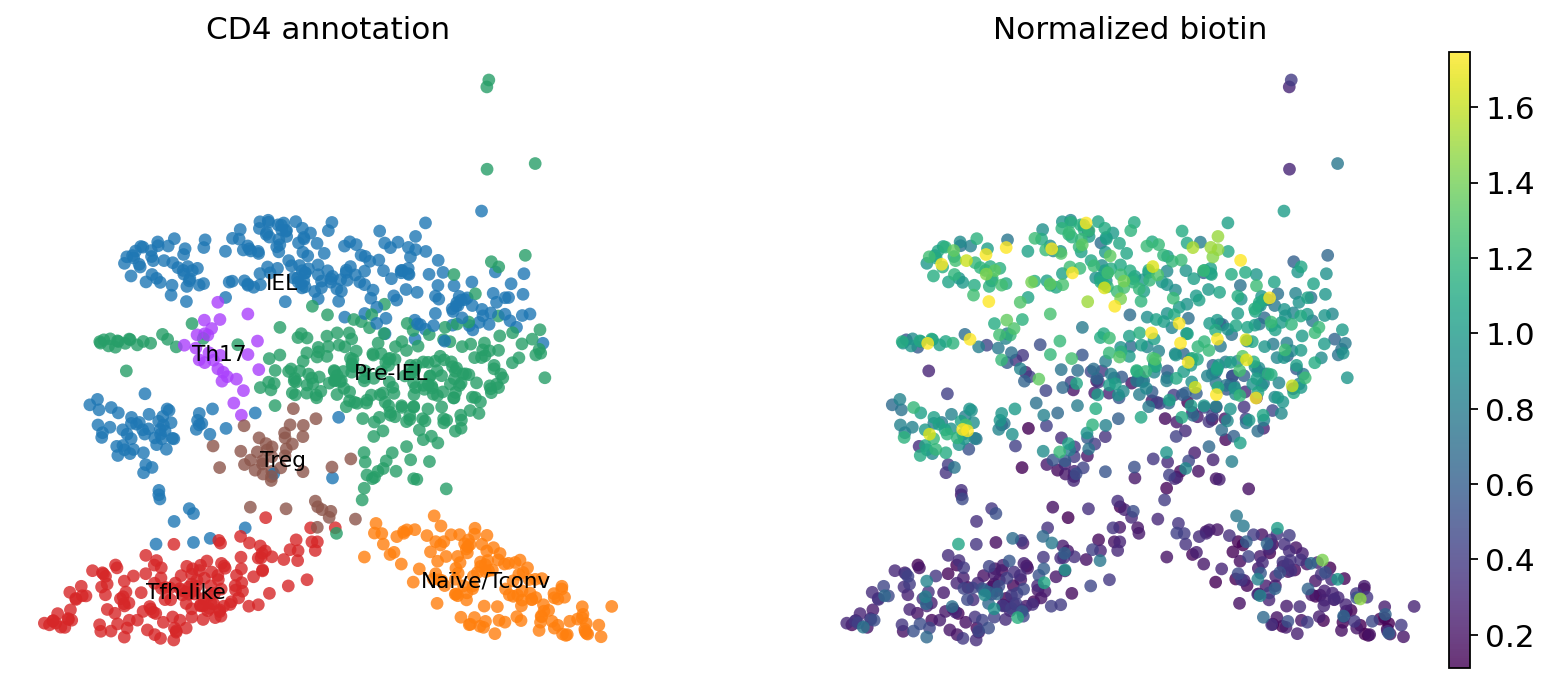

In [26]:
sc.set_figure_params(figsize=(5,5), vector_friendly=False)
sc.settings.figdir="paper_figures/"
sc.pl.umap(ad, color=[" cd4 annotation ", "normalized biotin"], vmin="p2", vmax="p98",
           color_map = "viridis", save="_panel_3.pdf", frameon=False, legend_loc = 'on data',
          legend_fontsize = "x-small", legend_fontweight="medium", alpha = 0.8, title=[
              "CD4 annotation", "Normalized biotin"
          ])

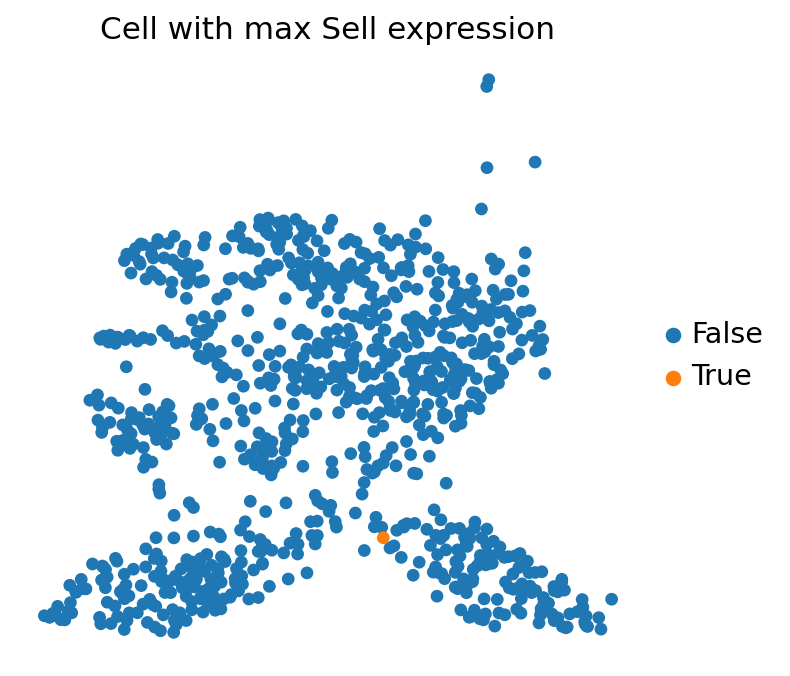

In [27]:
max_sell_i = np.argmax(ad[:, "Sell"].layers["pearson_theta_1"])
ad.obs["max_sell"] = (ad.obs_names == ad.obs_names[max_sell_i]).astype(str)
sc.pl.umap(ad, color=["max_sell"], layer="pearson_theta_1", frameon=False, title = "Cell with max Sell expression")

## generating stuff for trajectory + clonal diversity panel

In [28]:
ad.X = ad.layers["raw_counts"].todense().copy()
sc.pp.normalize_per_cell(ad)
sc.pp.pca(ad)
sc.tl.tsne(adata=ad, n_pcs=30, perplexity=30)
sc.pp.neighbors(ad, n_pcs=30, n_neighbors=10)
sc.tl.diffmap(ad, n_comps=30)

/Genomics/grid/users/skwalker/new_scvi/lib/python3.9/site-packages/anndata/compat/__init__.py:263: FutureWarning: During AnnData slicing, found matrix at .uns['clone_id']['distances'] that happens to be dimensioned at n_obs×n_obs (915×915).

These matrices should now be stored in the .obsp attribute.
This slicing behavior will be removed in anndata 0.8.
/Genomics/grid/users/skwalker/new_scvi/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.


In [29]:
sc.external.tl.wishbone(adata=ad, start_cell = ad.obs_names[ad.obs["max_sell"] == "True"].values[0],
    components=[1, 2], num_waypoints=150,
)

Building lNN graph...
lNN computed in : 0.01 seconds
Determining waypoints if not specified...
Determining shortest path distances and perspectives....
......................................................................................................................................................
Time for determining distances and perspectives: 3.91 seconds
Determining branch point and branch associations...
Running iterations...
Iteration: 2
Correlation with previous iteration:  0.9997
1 realignment iterations


In [30]:
ad.obs["clone id size"] = ad.obs["clone_id_size"].astype("category")

In [31]:
vlag_cmap = mpl.cm.get_cmap("vlag")(np.linspace(0,1,30))
vlag_cmap = vlag_cmap-0.1
# testing = np.concatenate([vlag_cmap[0:8], vlag_cmap[8:10]-0.05, vlag_cmap[10:12]-0.1, vlag_cmap[12:14]-0.15, 
#                          vlag_cmap[14:17]-0.2, vlag_cmap[17:19]-0.15, vlag_cmap[19:21]-0.1, vlag_cmap[21:23]-0.05,
#                          vlag_cmap[17:-1]])
vlag_cmap[:, 3] = 1.0
vlag_cmap = mpl.colors.ListedColormap(vlag_cmap)

## <font color = "navy"> Main figure 4E

findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


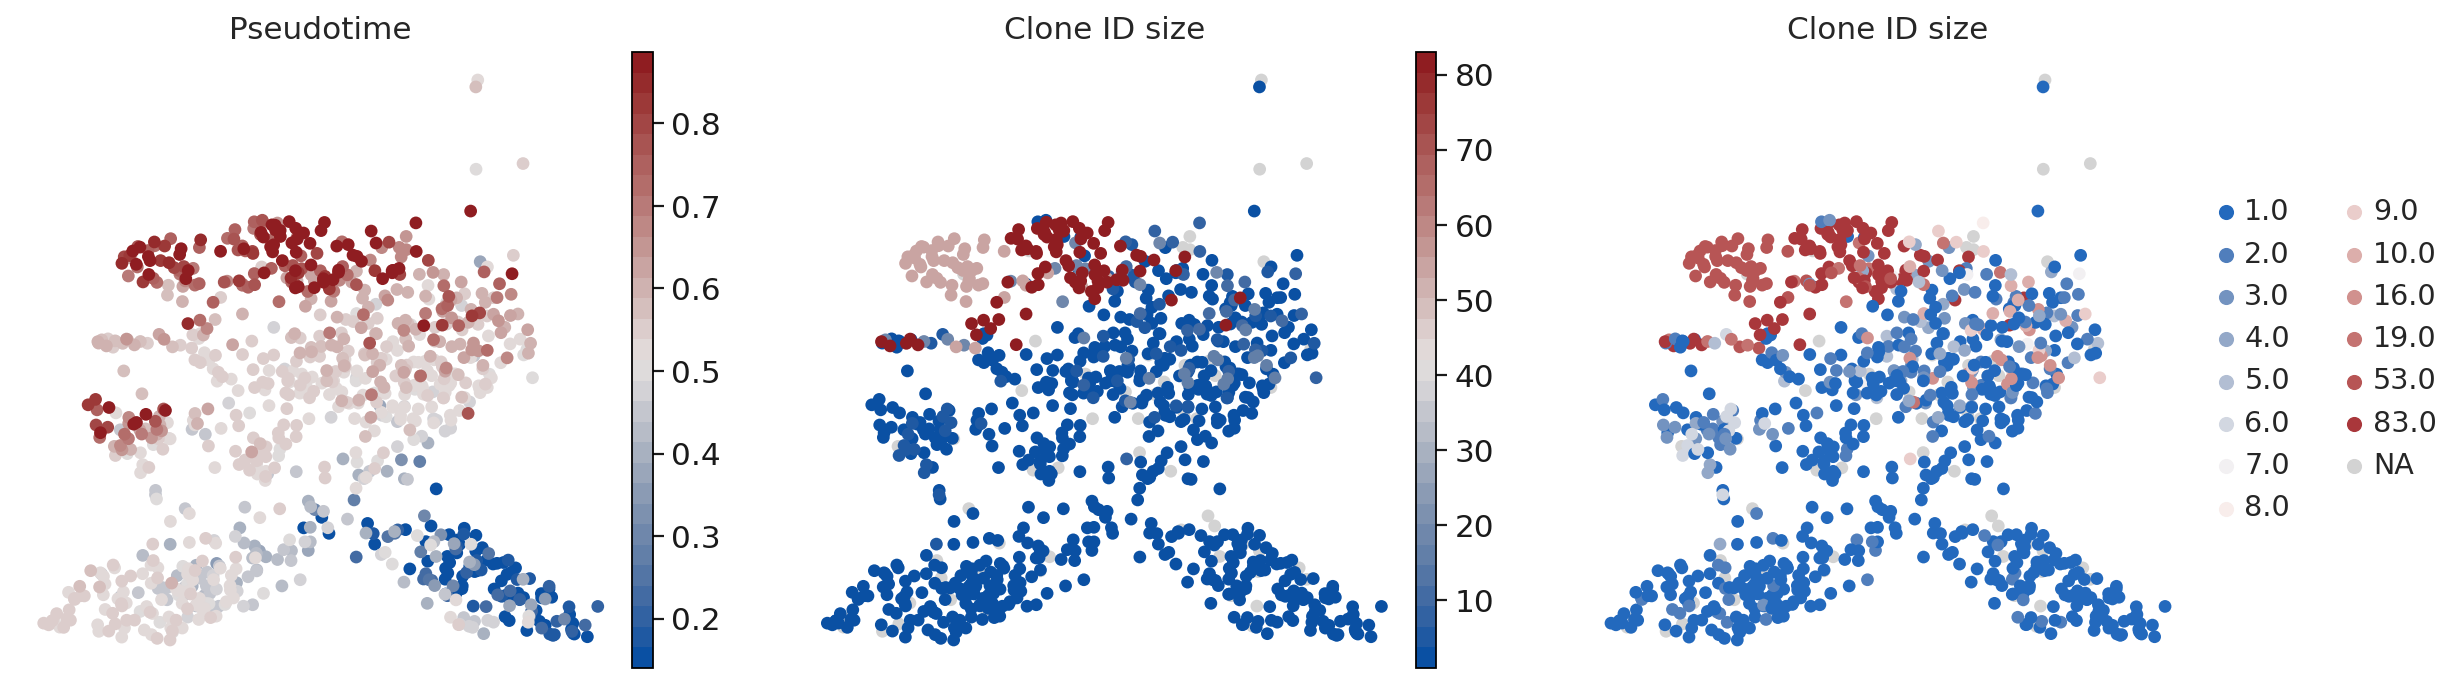

In [32]:
%matplotlib inline
sc.set_figure_params(figsize=(5,5), vector_friendly=False)
sc.settings.figdir="paper_figures/"
sc.pl.umap(ad, color=['trajectory_wishbone', "clone_id_size", "clone id size"],
           cmap=vlag_cmap, vmin="p5", vmax="p95", title = ["Pseudotime", "Clone ID size", "Clone ID size"],
           frameon = False, save="_panel_4.pdf", palette = "vlag")

/Genomics/grid/users/skwalker/new_scvi/lib/python3.9/site-packages/wishbone/wb.py:1624: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/Genomics/grid/users/skwalker/new_scvi/lib/python3.9/site-packages/wishbone/wb.py:1624: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/Genomics/grid/users/skwalker/new_scvi/lib/python3.9/site-packages/wishbone/wb.py:1624: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/Genomics/grid/users/skwalker/new_scvi/lib/python3.9/site-packages/wishbone/wb.py:1624: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/Genomics/grid/users/skwalker/new_scvi/lib/python3.9/site-packages/wishbone/wb.py:1624: FutureWarning: The serie

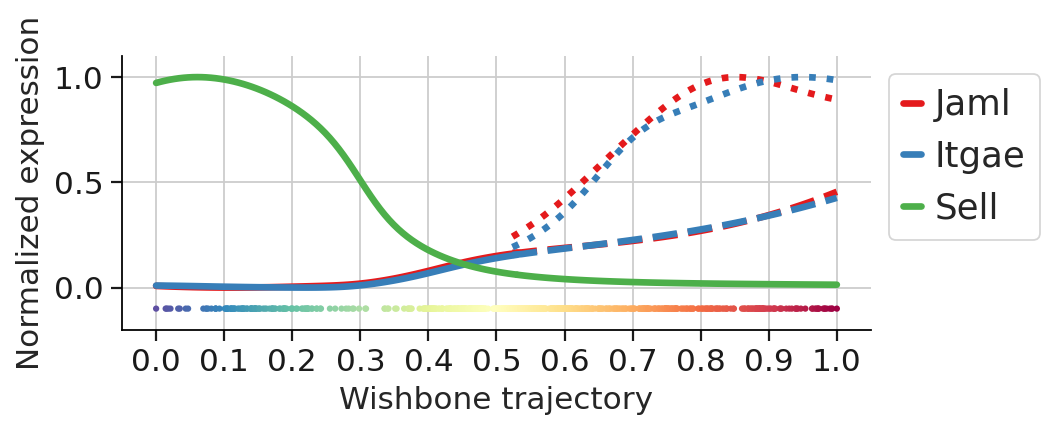

In [33]:
sc.external.pl.wishbone_marker_trajectory(ad, ["Jaml", "Itgae", "Sell"])

## Make sure that trying different cells for general starting location doesn't affect pseudotime analysis

In [34]:
def testing_wishbone_roots(ad):
    ad.X = ad.layers["raw_counts"].copy()
    sc.pp.normalize_per_cell(ad)
    sc.pp.pca(ad)
    sc.tl.tsne(adata=ad, n_pcs=30, perplexity=30)
    sc.pp.neighbors(ad, n_pcs=15, n_neighbors= 30)
    sc.tl.diffmap(ad, n_comps=10)
    root_cells = np.random.choice(ad.obs_names[ad.obs.leiden == "1"], 15)
    ad.obs["root_cell"] = [str (cell in root_cells) for cell in ad.obs_names]
    sc.pl.umap(ad, color="root_cell")
    sc.pl.diffmap(ad, color="leiden", )
    wishbone_results = pd.DataFrame()
    for root_cell in root_cells:
        sc.external.tl.wishbone(adata = ad, start_cell = root_cell, components=[1,2], num_waypoints=150)
        wishbone_results = pd.concat([wishbone_results, pd.DataFrame({"root cell": root_cell,
                                                                      "pseudotime": ad.obs.trajectory_wishbone})])
    ad.X = ad.layers["pearson_theta_1"].copy()
    return wishbone_results

/Genomics/grid/users/skwalker/new_scvi/lib/python3.9/site-packages/anndata/compat/__init__.py:263: FutureWarning: During AnnData slicing, found matrix at .uns['clone_id']['distances'] that happens to be dimensioned at n_obs×n_obs (915×915).

These matrices should now be stored in the .obsp attribute.
This slicing behavior will be removed in anndata 0.8.
/Genomics/grid/users/skwalker/new_scvi/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.


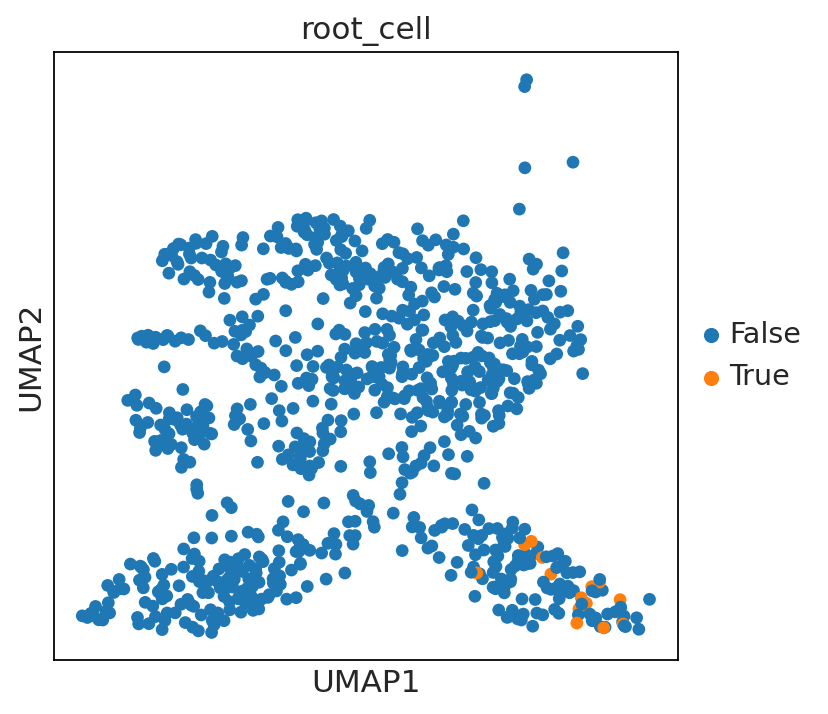

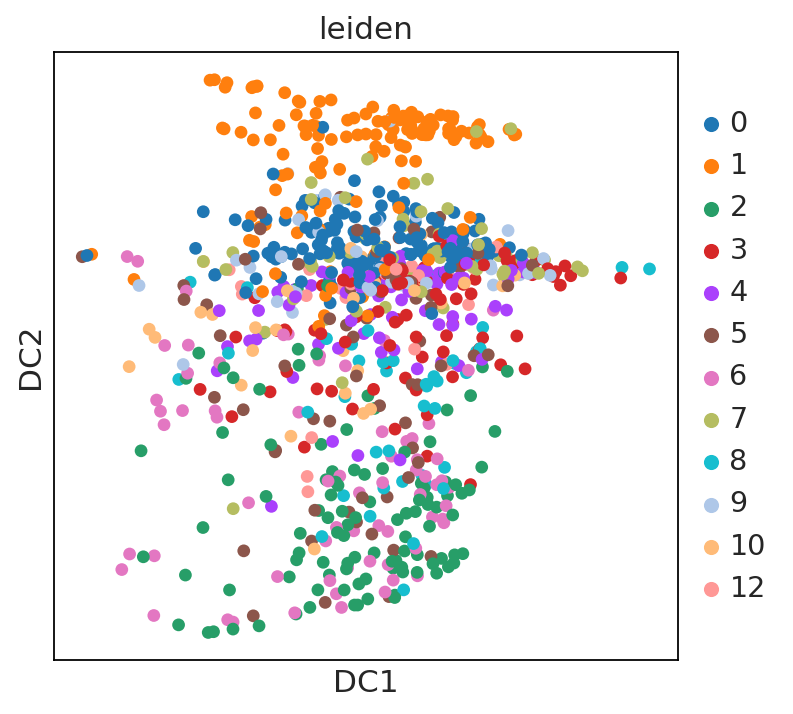

Building lNN graph...
lNN computed in : 0.00 seconds
Determining waypoints if not specified...
Determining shortest path distances and perspectives....
......................................................................................................................................................
Time for determining distances and perspectives: 4.09 seconds
Determining branch point and branch associations...
Running iterations...
Iteration: 2
Correlation with previous iteration:  0.9994
1 realignment iterations
Building lNN graph...
lNN computed in : 0.70 seconds
Determining waypoints if not specified...
Determining shortest path distances and perspectives....
......................................................................................................................................................
Time for determining distances and perspectives: 5.60 seconds
Determining branch point and branch associations...
Running iterations...
Iteration: 2
Correlation with previous 

In [35]:
test_wishbone = testing_wishbone_roots(ad)

In [36]:
test_wishbone = test_wishbone.reset_index().rename(columns={"index": "cell"}).pivot_table(
    index="cell", columns = "root cell", values="pseudotime")

In [37]:
sc.external.tl.wishbone(adata=ad, start_cell = ad.obs_names[ad.obs["max_sell"] == "True"].values[0],
    components=[1, 2], num_waypoints=150,
)

Building lNN graph...
lNN computed in : 0.34 seconds
Determining waypoints if not specified...
Determining shortest path distances and perspectives....
......................................................................................................................................................
Time for determining distances and perspectives: 4.01 seconds
Determining branch point and branch associations...
Running iterations...
Iteration: 2
Correlation with previous iteration:  0.9996
1 realignment iterations


In [38]:
test_wishbone["current root"] = ad.obs["trajectory_wishbone"]

## calculate pseudotime correlations for every pair of root cells

In [39]:
from itertools import permutations
root_corrs = pd.DataFrame()
for c1, c2 in list(permutations(test_wishbone.columns[::-1], 2)):
    root_corrs = pd.concat([root_corrs, pd.DataFrame({"root 1": [c1], "root 2": [c2], "corr": [spearmanr(
        test_wishbone[c1], test_wishbone[c2])[0]]})])

In [40]:
np.unique(root_corrs["root 2"])

array(['ACGGCCACAGTCACTA-1', 'ATCATCTAGGGTGTTG-1', 'CACTCCACAATGGAAT-1',
       'CATCAAGGTAGGCATG-1', 'CGCGGTAGTCTCCCTA-1', 'CGTTCTGCAAGCTGAG-1',
       'CTGTTTAAGGTAAACT-1', 'GAATGAACATCCGGGT-1', 'GGACATTCAGGGCATA-1',
       'GTGTTAGTCAACGGGA-1', 'TAAACCGGTAGCGTAG-1', 'TAGTGGTAGACAGACC-1',
       'TCATTACGTTCCACAA-1', 'TGATTTCCATCACGTA-1', 'current root'],
      dtype=object)

In [41]:
root_corrs["current root"] = (root_corrs["root 2"] == "current root") | (root_corrs["root 1"] == "current root")

## mostly very consistent except for 2 choices of root cells

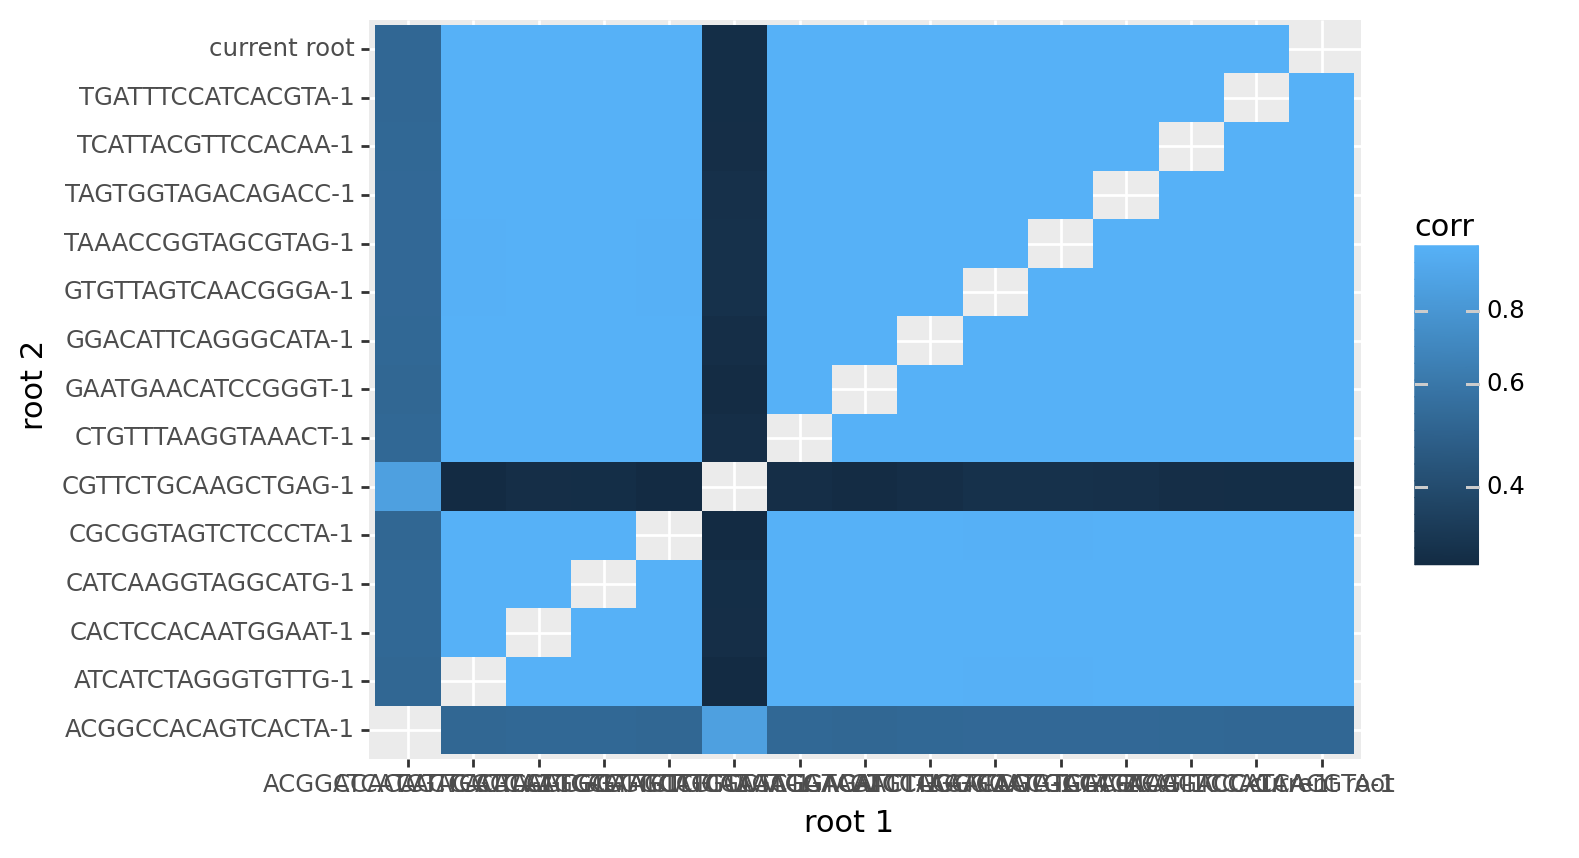

<ggplot: (8791746405154)>

In [42]:
ggplot(root_corrs, aes(x="root 1", y="root 2", fill="corr", label = "corr")) + geom_tile() + scale_fill_gradient(
    trans = "log")


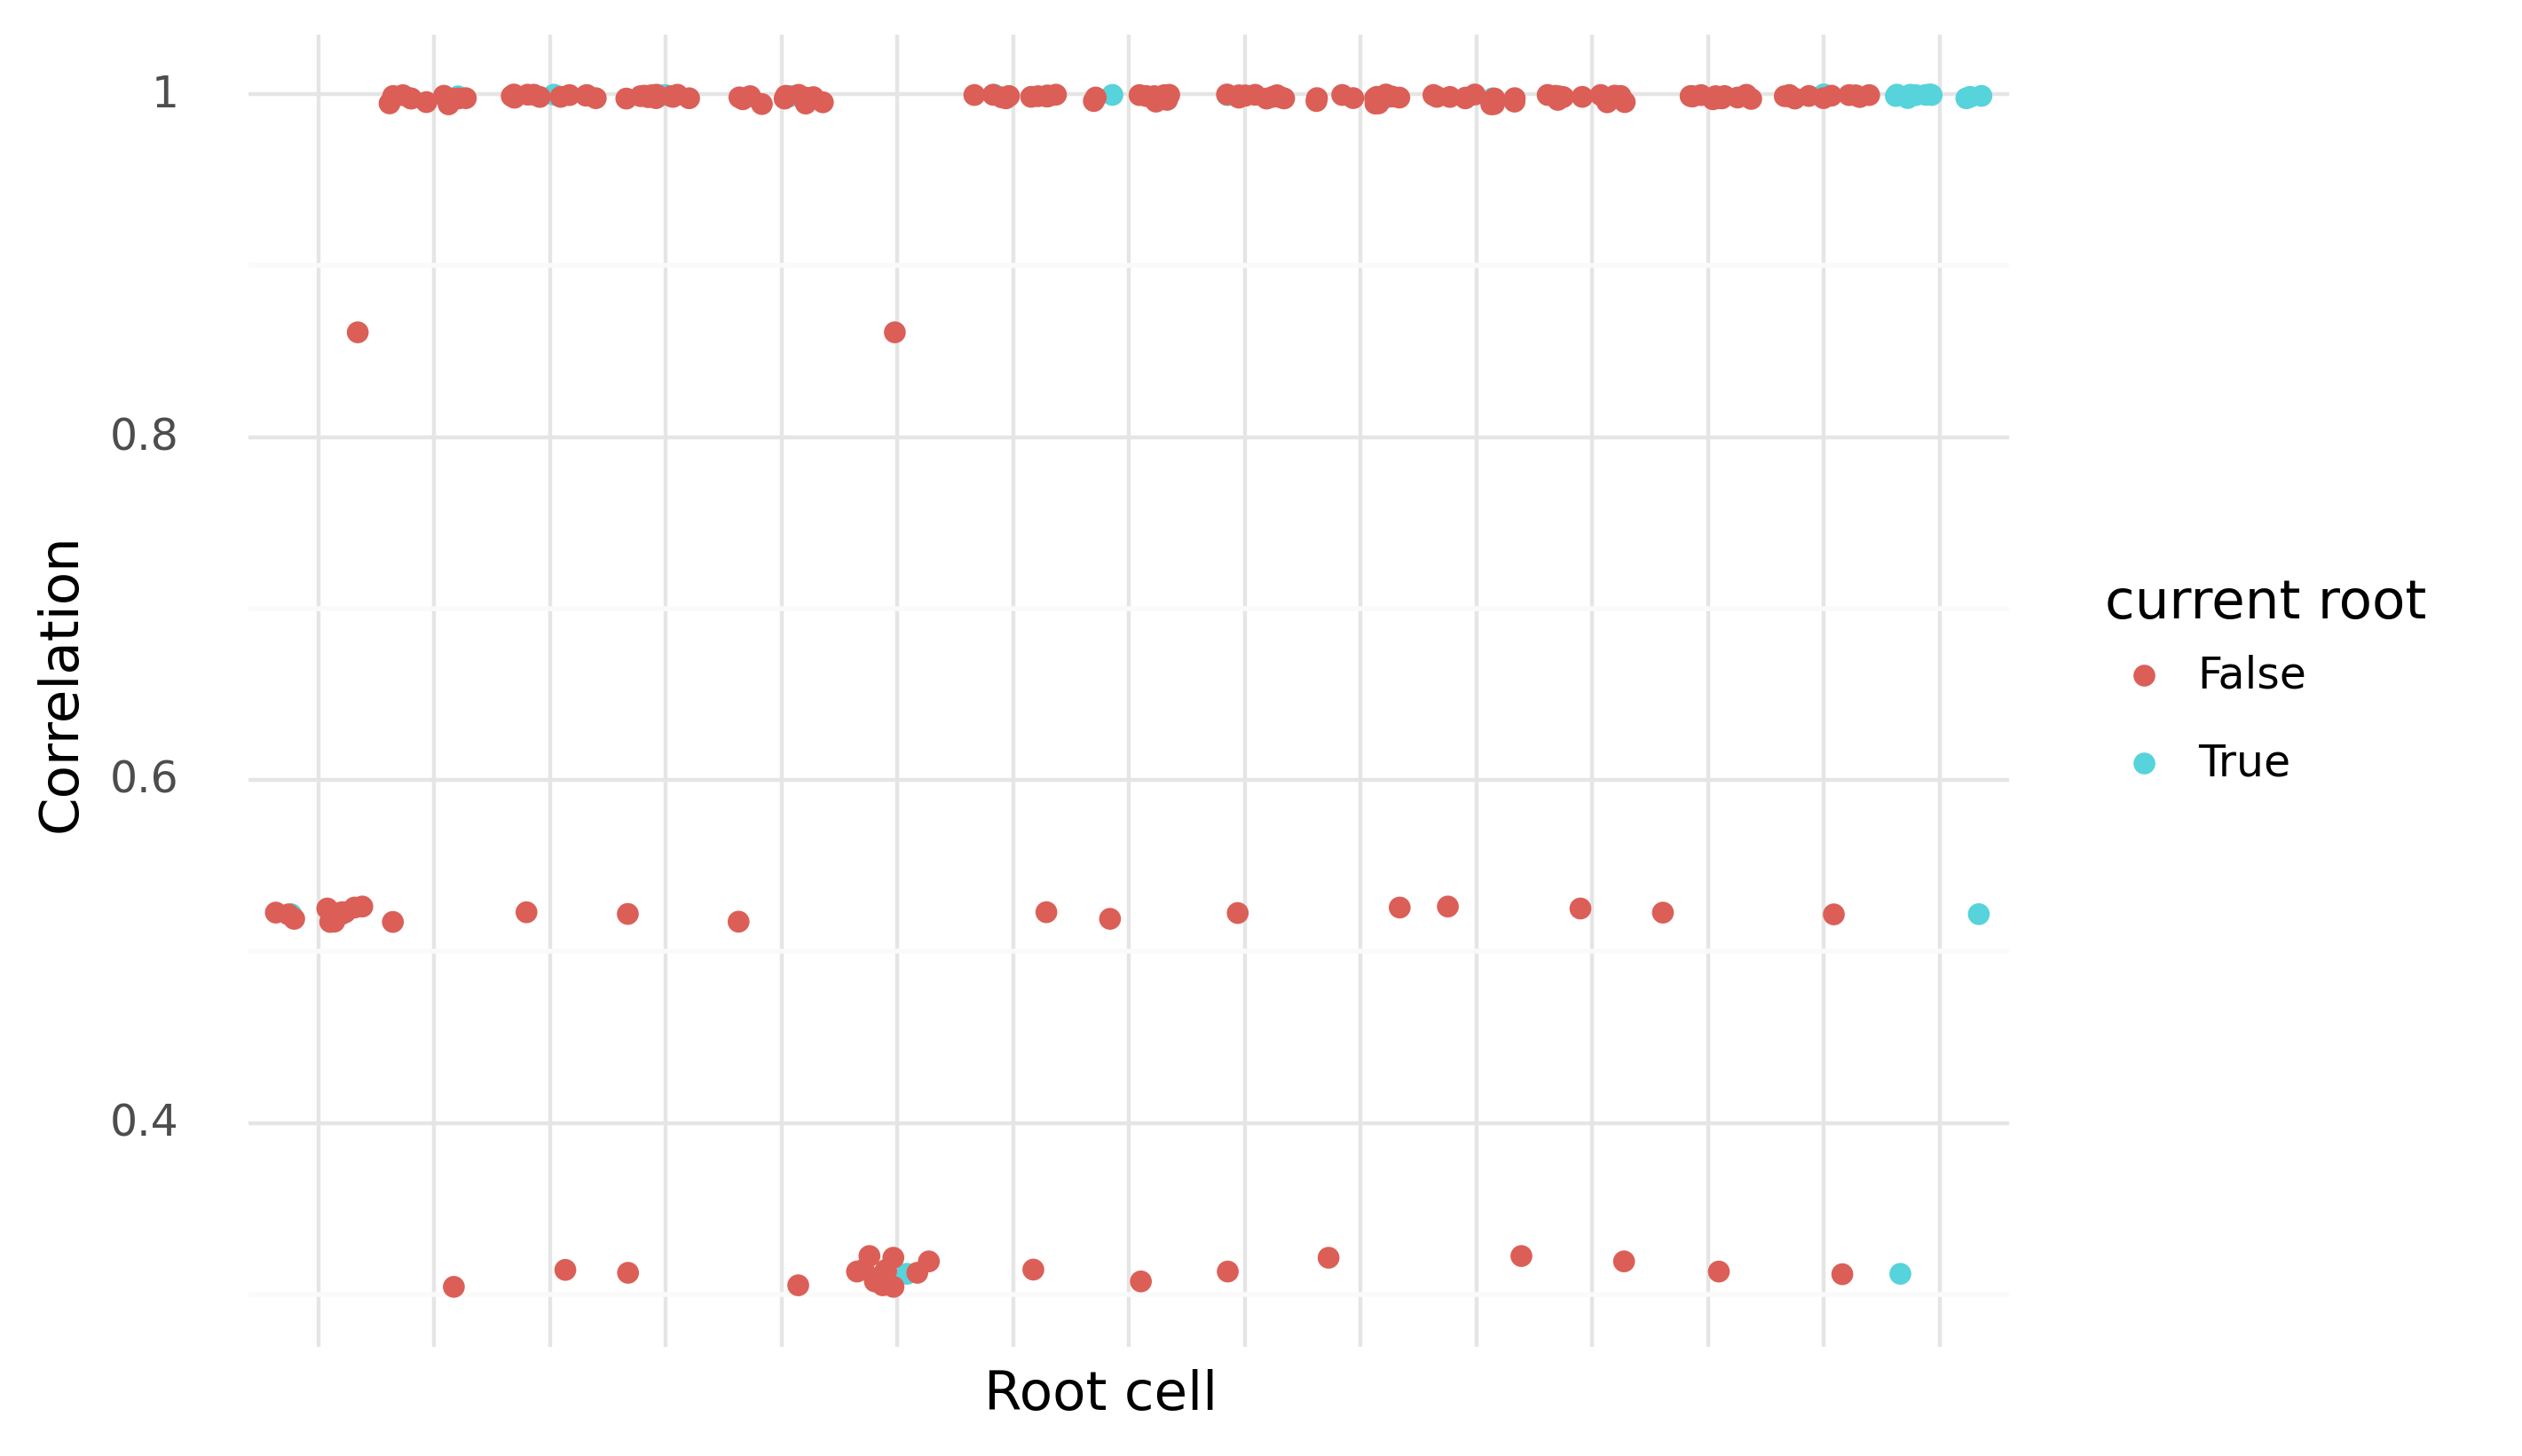

<ggplot: (8791746607999)>

In [43]:
ggplot(root_corrs, aes(x="root 1", y="corr", color = "current root")) + geom_point(position="jitter") + \
theme_minimal() + theme(dpi=200, axis_text_x=element_blank()) + labs(x="Root cell", y="Correlation")

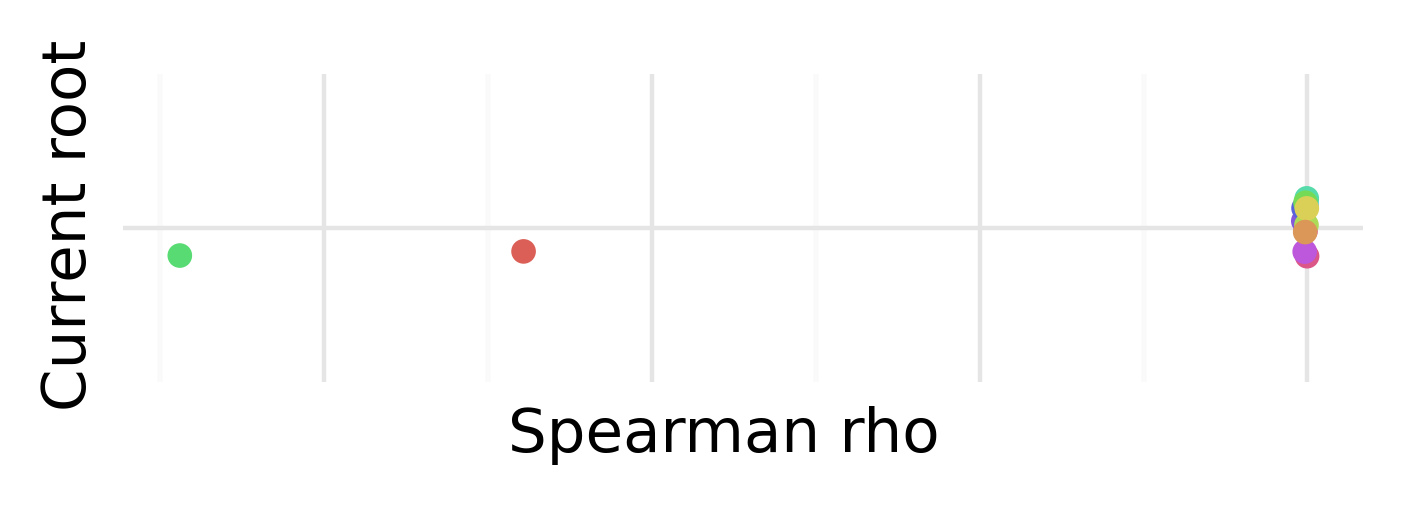

<ggplot: (8791782449619)>

In [44]:
p_corrs = ggplot(root_corrs[root_corrs["root 1"] == "current root"], aes(x="root 1", y="corr", color="root 2")) + \
geom_jitter(width=0.1, height=0) + theme_minimal() + coord_flip() + labs(y="Spearman rho", x="Current root") + \
theme(dpi=200, legend_position = "none", figure_size=(4,1), axis_text=element_blank())
p_corrs

In [45]:
ad.obs["  cd4 annotation  "] = ad.obs["cd4 annotation"].astype(CategoricalDtype(
        categories = ["Naïve/Tconv", "Tfh-like", "Treg", "Th17", "Pre-IEL", "IEL"], ordered = True))

## <font color = "navy"> Main figure 4F

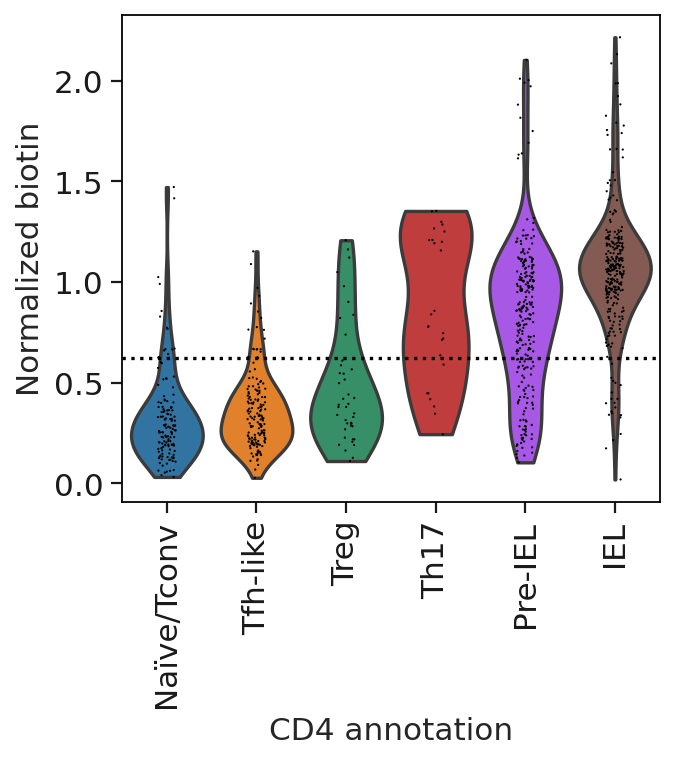

In [46]:
sc.set_figure_params(figsize=(4.5, 4), vector_friendly=False)
norm_biotin_pos_threshold =0.622704307752874 ## from previous notebook, this should be saved in helper functions
ax = sc.pl.violin(ad, groupby="  cd4 annotation  ", keys = "normalized biotin", ax = None, show = False, rotation=90)
ax.grid(False)
ax.axhline(norm_biotin_pos_threshold, color = "black", linestyle="dotted")
plt.xlabel("CD4 annotation")
plt.ylabel("Normalized biotin")
plt.savefig("paper_figures/violin_panel_5.pdf",  bbox_inches='tight')
sc.set_figure_params(figsize=(5,5))

## explore some clones, see how they are shared across cell types/clusters

In [47]:
cluster_clone_df = pd.DataFrame()
for cl in np.unique(ad.obs["cd4 cluster"]):
    filtered_ad = ad[(ad.obs.clone_id.isin(ad.obs[ad.obs["cd4 cluster"] == cl][["clone_id"]].dropna(
    ).clone_id.unique())) & (ad.obs.clone_id_size > 1)]
    filtered_ad.obs.clone_id = filtered_ad.obs.clone_id.astype(CategoricalDtype(
        categories = filtered_ad.obs.sort_values("clone_id_size", ascending=False)["clone_id"].astype(
            str).unique(), ordered = True))
    new_df = filtered_ad.obs[["cd4 cluster", "clone_id", "clone_id_size"]]
    new_df["cluster"] = cl
    cluster_clone_df = pd.concat([cluster_clone_df, new_df])
cluster_clone_df.head()

/Genomics/grid/users/skwalker/new_scvi/lib/python3.9/site-packages/anndata/compat/__init__.py:263: FutureWarning: During AnnData slicing, found matrix at .uns['clone_id']['distances'] that happens to be dimensioned at n_obs×n_obs (915×915).

These matrices should now be stored in the .obsp attribute.
This slicing behavior will be removed in anndata 0.8.
/Genomics/grid/users/skwalker/new_scvi/lib/python3.9/site-packages/pandas/core/generic.py:5604: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/tmp/ipykernel_102559/4255035361.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Genomics/grid/users/skwalker/new_scvi/lib/python3.9/site-packages/anndata/compat/__init__.py:263: FutureWarning: During

/tmp/ipykernel_102559/4255035361.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


cd4 cluster clone_id  clone_id_size cluster
AAATGCCCATCGGTTA-1       cd4_0       23            2.0   cd4_0
AACCATGCAATCGGTT-1       cd4_0       30            2.0   cd4_0
ACCTTTATCCGTTGCT-1       cd4_8       99            2.0   cd4_0
ACGATACAGTGTACTC-1       cd4_0      104            2.0   cd4_0
ACTTACTCAAGTTAAG-1       cd4_0      152            2.0   cd4_0

In [48]:
# levels = [ np.where(ad.obs[level].cat.categories == cl)[0][0] for cl in np.unique(df[level])]
cluster_clone_df["clone_id"] = cluster_clone_df["clone_id"].astype(CategoricalDtype(
    ordered = True, categories=cluster_clone_df.sort_values("clone_id_size", ascending = False)["clone_id"].unique()))
cluster_clone_df["cluster"] = cluster_clone_df["cluster"].astype(CategoricalDtype(categories=[ 
    "cd4_%s"%i for i in range(12)], ordered = True))
cluster_clone_df["cd4 cluster"] = cluster_clone_df["cd4 cluster"].astype(CategoricalDtype(categories=[ 
    "cd4_%s"%i for i in range(12)], ordered = True))

In [49]:
counting_df = cluster_clone_df[["clone_id", "clone_id_size", "cluster"]].drop_duplicates(ignore_index = True)
counting_df["clone_id_size"] = counting_df["clone_id_size"].astype(int)

In [50]:
p = ggplot(cluster_clone_df, aes(x="clone_id", fill="cd4 cluster")) + geom_bar(position = "fill") + facet_wrap(
    "~ cluster", scales="free_x", ncol=4) + theme_minimal() + theme(axis_text_x = element_blank(
), dpi = 200, axis_ticks_major_x=element_blank(), figure_size=(15, 9)) + \
scale_fill_manual(ad.uns["cd4 cluster_colors"]) + geom_text(counting_df, aes(
    x="clone_id", label="clone_id_size"), color="black",y=1.01, inherit_aes=False, size = 8.5) + labs(
    x="TCR Clone", y="Fraction of cells in clone from each cluster")

/Genomics/grid/users/skwalker/new_scvi/lib/python3.9/site-packages/plotnine/facets/facet.py:440: PlotnineWarning: If you need more space for the y-axis tick text use ... + theme(subplots_adjust={'hspace': 0.25}). Choose an appropriate value for 'hspace'


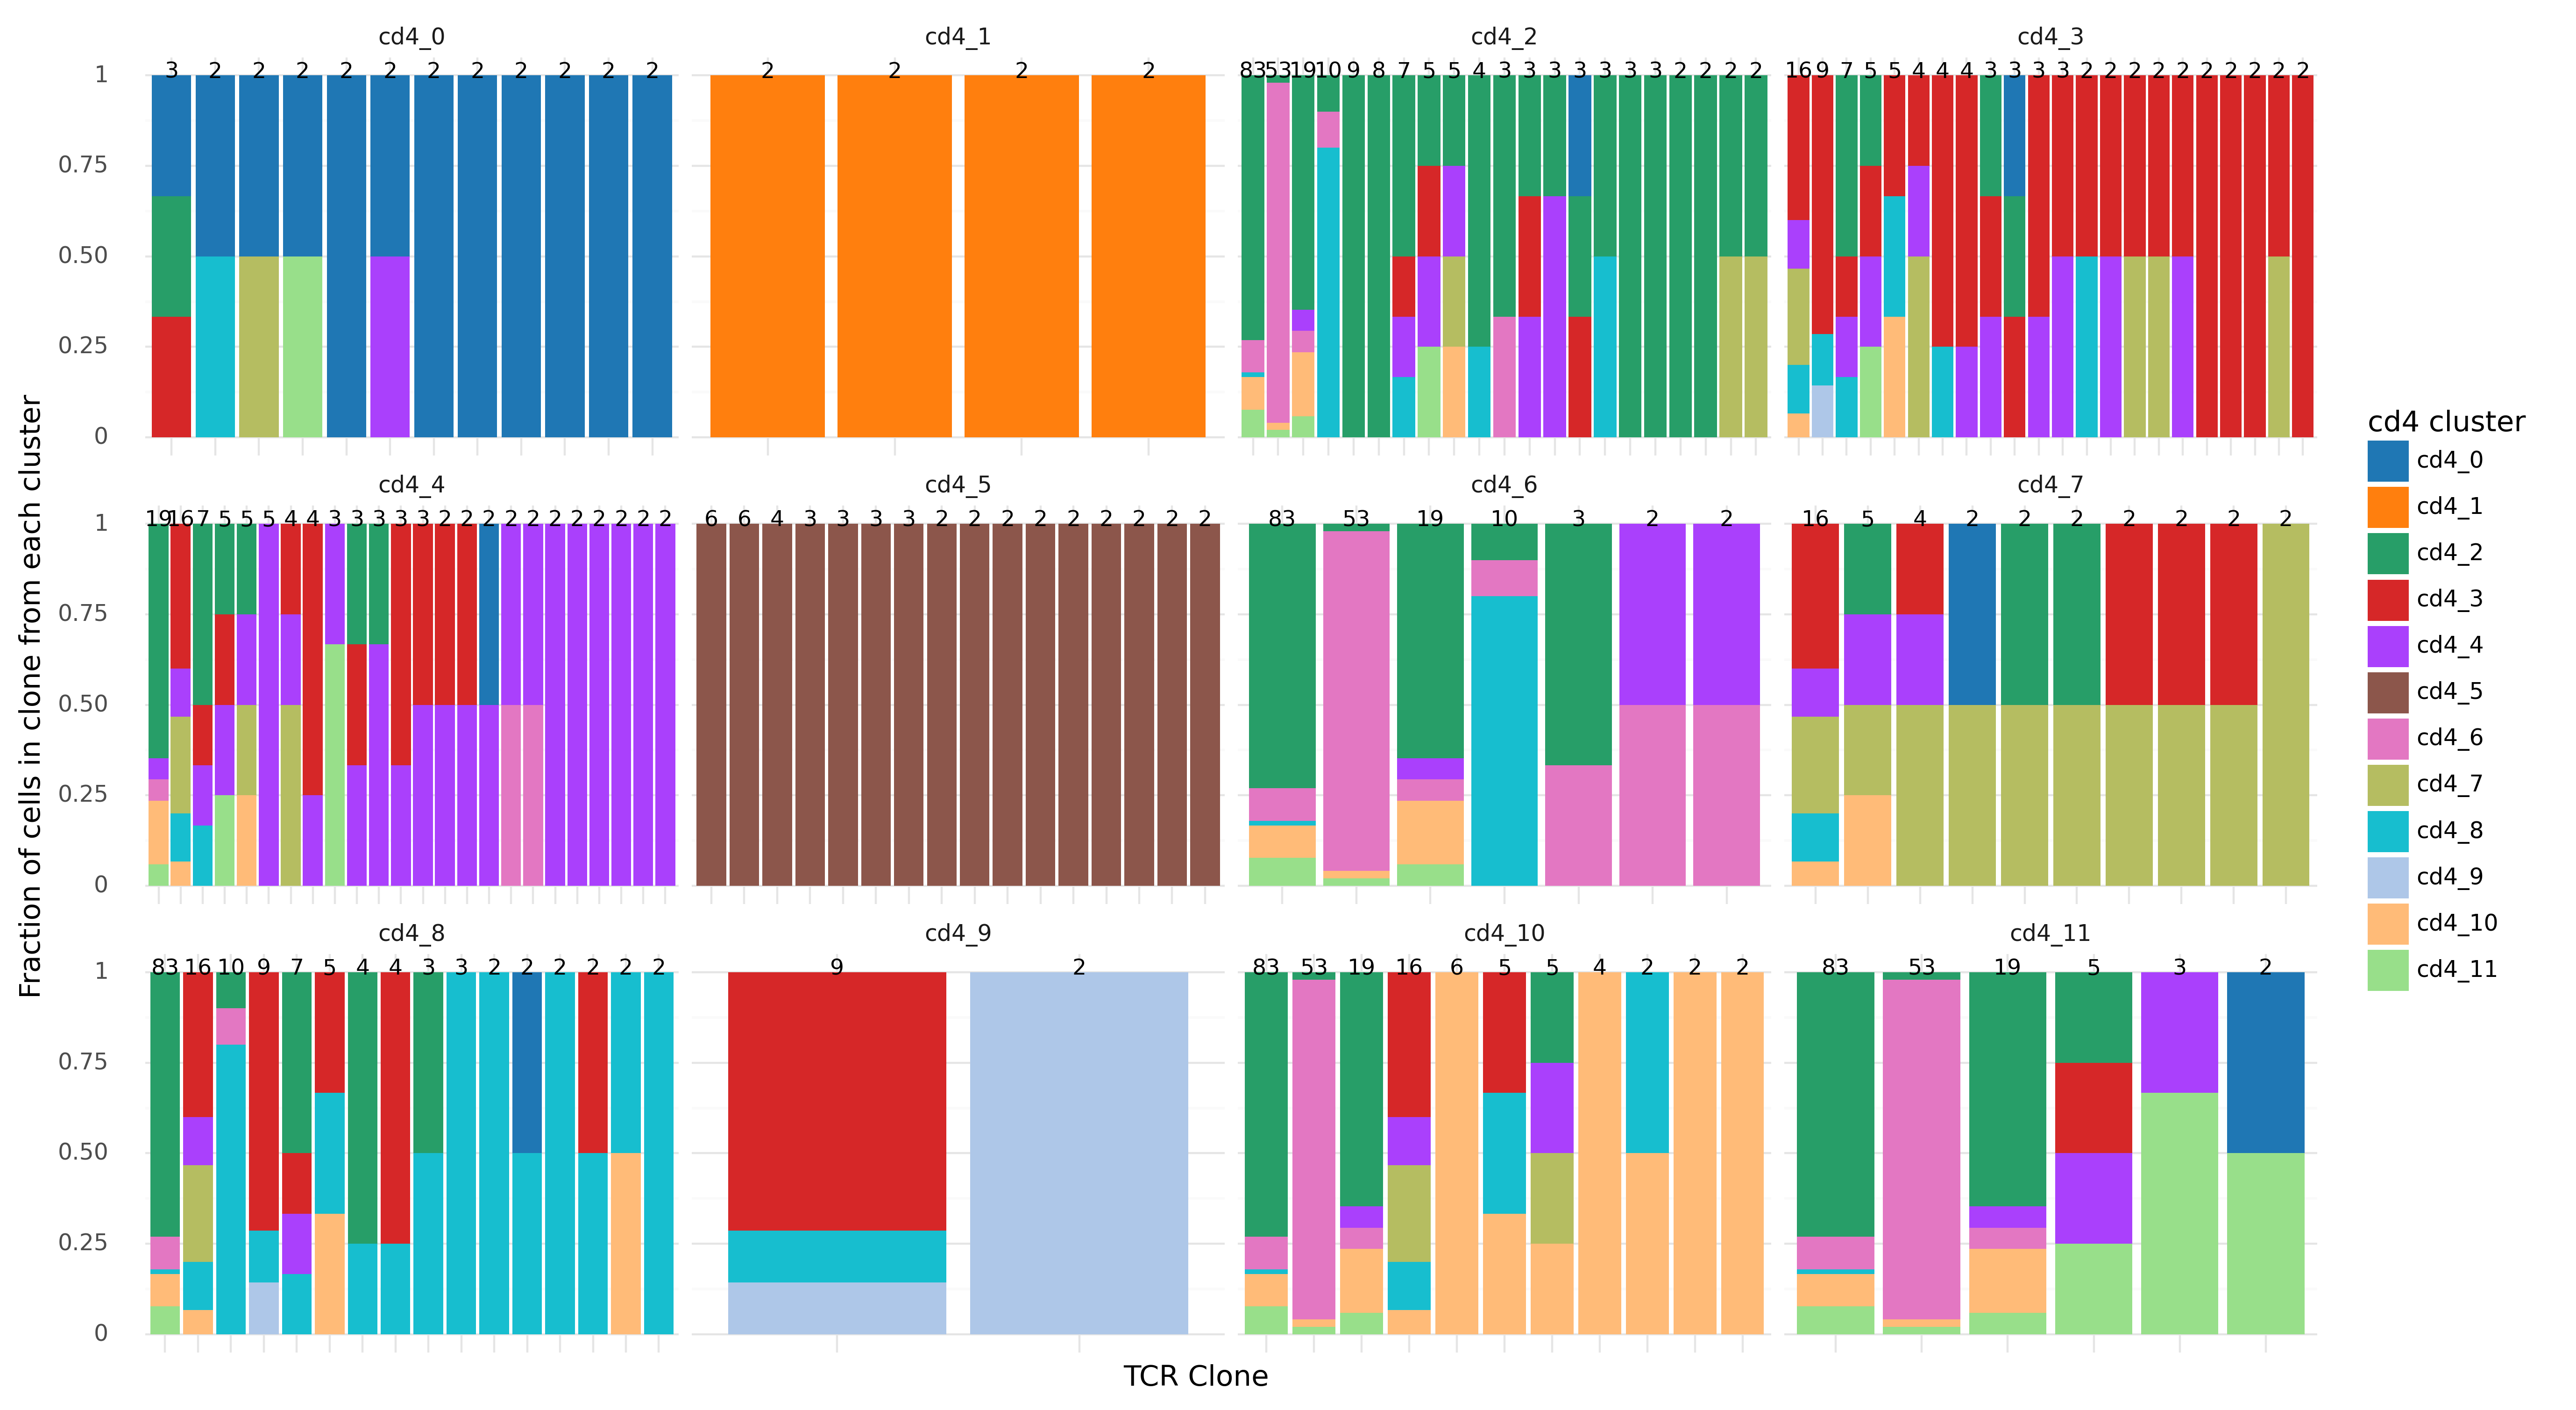

<ggplot: (8791746270067)>

In [51]:
p

In [52]:
ggsave(p, "paper_figures/supplemental/cd4/clone_sharing.pdf")

/Genomics/grid/users/skwalker/new_scvi/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 15 x 9 in image.
/Genomics/grid/users/skwalker/new_scvi/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: paper_figures/supplemental/cd4/clone_sharing.pdf
/Genomics/grid/users/skwalker/new_scvi/lib/python3.9/site-packages/plotnine/facets/facet.py:440: PlotnineWarning: If you need more space for the y-axis tick text use ... + theme(subplots_adjust={'hspace': 0.25}). Choose an appropriate value for 'hspace'


## now look into correlations between gene expression and biotin levels

In [53]:
# selecting some interesting genes that correlate strongly with biotin levels
cd4_genes = ["Nkg7", "Ccl5", "Slamf6", "Lef1", "Gzma", "Gzmb", "Id2", "Itgae", "Jaml", "Sell", "Tcf7", "Itgb7"]

In [54]:
from scipy.stats import spearmanr

In [55]:
cd4_spearman_df = make_corr_df(ad)

In [56]:
cd4_spearman_df["padj"] = cd4_spearman_df["pval"] * cd4_spearman_df.shape[0]

In [57]:
cd4_spearman_df.head()

gene      corr           pval  interesting gene    i           padj
4670  Tmsb10 -0.656227  8.712363e-114             False  0.0  1.248656e-109
8666    Tcf7 -0.602771   1.338770e-91              True  0.1   1.918725e-87
8392    Dgka -0.527083   1.482648e-66             False  0.2   2.124931e-62
2583   Rps20 -0.512907   1.546243e-62             False  0.3   2.216075e-58
7677    Rpsa -0.495680   6.672235e-58             False  0.4   9.562647e-54

In [58]:
cd4_spearman_df.drop(columns=["i", "interesting gene"]).sort_values("corr", ascending=False).to_excel(
    "supplementary_tables/CD4_correlations.xls", index=False)

/tmp/ipykernel_102559/2302832532.py:1: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.


In [59]:
np.max(cd4_spearman_df[cd4_spearman_df["interesting gene"]]["pval"])

1.0960035169728495e-28

In [60]:
worst_fdr = np.max(cd4_spearman_df[cd4_spearman_df["interesting gene"]]["pval"]*cd4_spearman_df.shape[0])

In [61]:
worst_fdr

1.570792240525488e-24

In [62]:
worst_fdr < 1e-23

True

In [63]:
cd4_spearman_df.shape[0]

14332

## <font color = navy> Main figure 4G

In [64]:
cd4_spearman_df.shape

(14332, 6)

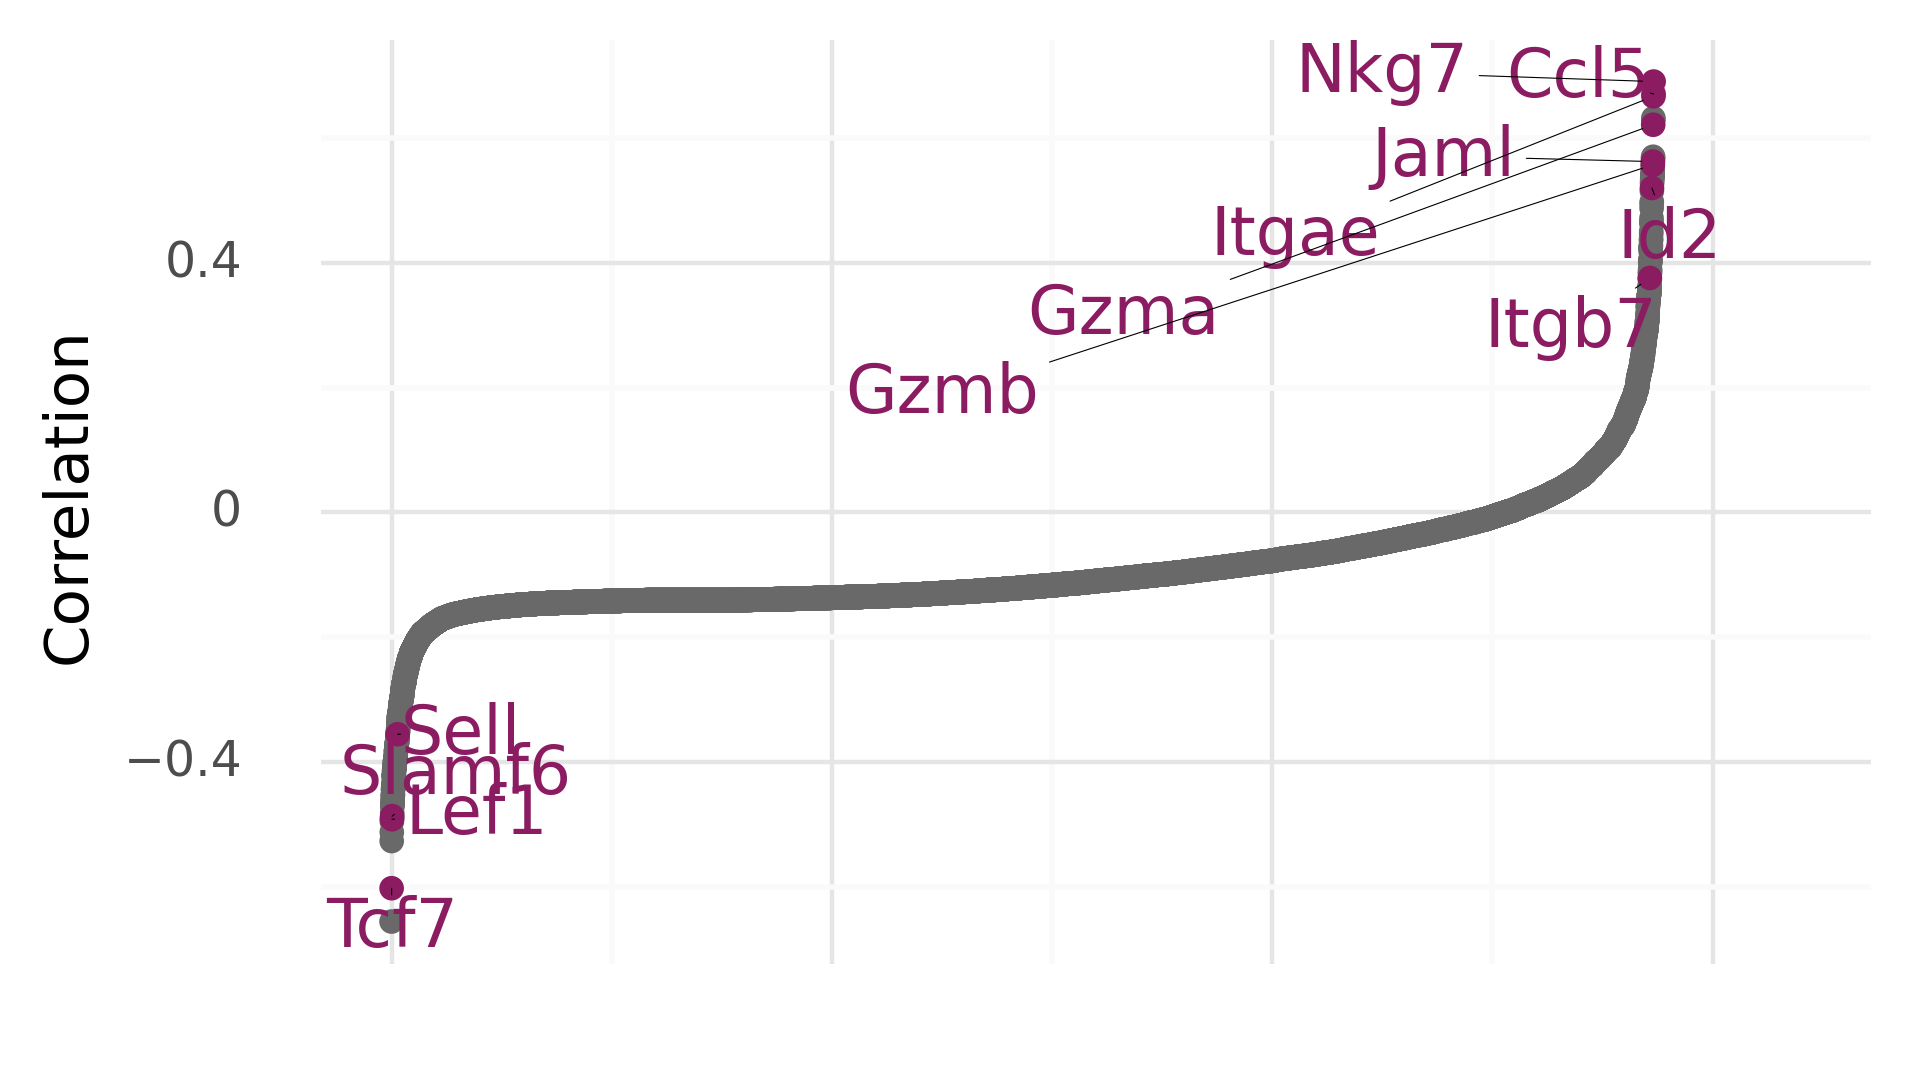

<ggplot: (8791745780529)>

In [65]:
p = make_corr_plot(cd4_spearman_df)
p

In [66]:
ggsave(p, "paper_figures/corrs_panel_6.pdf")

/Genomics/grid/users/skwalker/new_scvi/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 5 x 3 in image.
/Genomics/grid/users/skwalker/new_scvi/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: paper_figures/corrs_panel_6.pdf


## Make sure correlations are consistent across the 3 different samples

In [67]:
cd4_spearmans = pd.DataFrame()
for s in ad.obs["sample"].unique():
    df =  make_corr_df(ad[ad.obs["sample"] == s])
    df['sample'] = s
    cd4_spearmans = pd.concat([cd4_spearmans, df])

/Genomics/grid/users/skwalker/new_scvi/lib/python3.9/site-packages/anndata/compat/__init__.py:263: FutureWarning: During AnnData slicing, found matrix at .uns['clone_id']['distances'] that happens to be dimensioned at n_obs×n_obs (915×915).

These matrices should now be stored in the .obsp attribute.
This slicing behavior will be removed in anndata 0.8.
/Genomics/grid/users/skwalker/new_scvi/lib/python3.9/site-packages/anndata/compat/__init__.py:263: FutureWarning: During AnnData slicing, found matrix at .uns['clone_id']['distances'] that happens to be dimensioned at n_obs×n_obs (915×915).

These matrices should now be stored in the .obsp attribute.
This slicing behavior will be removed in anndata 0.8.
/Genomics/grid/users/skwalker/new_scvi/lib/python3.9/site-packages/anndata/compat/__init__.py:263: FutureWarning: During AnnData slicing, found matrix at .uns['clone_id']['distances'] that happens to be dimensioned at n_obs×n_obs (915×915).

These matrices should now be stored in the .ob

In [68]:
cd4_spearmans.head()

gene      corr          pval  interesting gene    i sample
4670   Tmsb10 -0.574919  6.441820e-32             False  0.0  IEL 4
8666     Tcf7 -0.542788  5.600257e-28              True  0.1  IEL 4
679    Slamf6 -0.503520  1.050593e-23              True  0.2  IEL 4
6161  Tspan32 -0.495848  6.216352e-23             False  0.3  IEL 4
6974  Izumo1r -0.480384  1.958246e-21             False  0.4  IEL 4

## <font color = "purple"> Supplemental figure, panel 11D

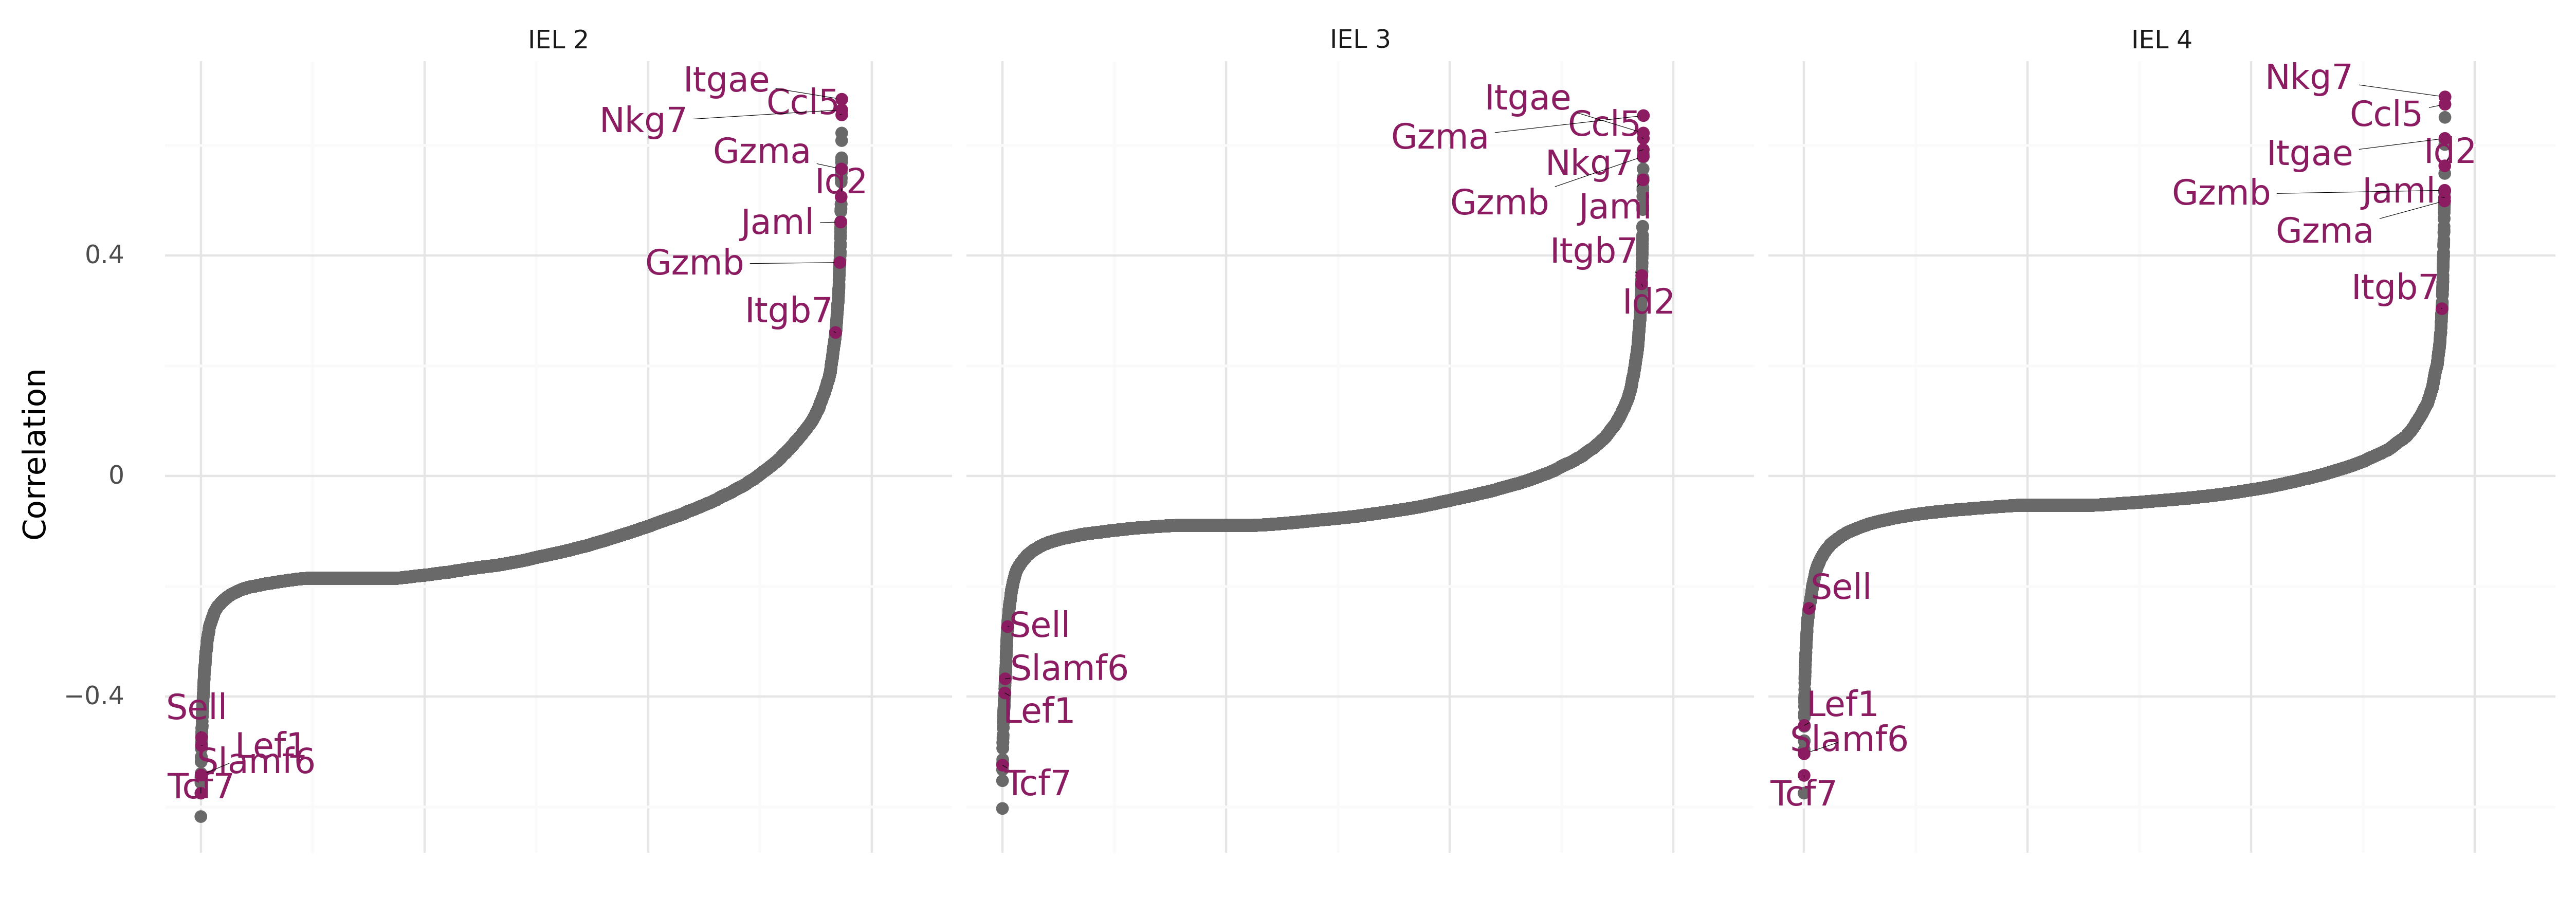

<ggplot: (8791676894531)>

In [69]:
cd4_supp = make_corr_plot(cd4_spearmans) + facet_wrap("~ sample") + theme(figure_size=(15, 5))
cd4_supp

In [70]:
ggsave(cd4_supp, "paper_figures/supplemental/cd4/sample_cd4_biotin_corrs.pdf")

/Genomics/grid/users/skwalker/new_scvi/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 15 x 5 in image.
/Genomics/grid/users/skwalker/new_scvi/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: paper_figures/supplemental/cd4/sample_cd4_biotin_corrs.pdf


In [71]:
testing_corrs = cd4_spearmans.pivot(index = "gene", columns = "sample", values = "corr")
testing_corrs.head()

sample            IEL 2     IEL 3     IEL 4
gene                                       
0610009B22Rik -0.176720 -0.062415 -0.021278
0610009L18Rik -0.073334 -0.045192 -0.068122
0610010F05Rik -0.161953 -0.097071 -0.033670
0610010K14Rik -0.016378  0.062774 -0.210598
0610012G03Rik -0.123888 -0.014490  0.024517

In [72]:
spearmanr(testing_corrs["IEL 2"], testing_corrs["IEL 3"])

SpearmanrResult(correlation=0.6272250655254846, pvalue=0.0)

In [73]:
spearmanr(testing_corrs["IEL 2"], testing_corrs["IEL 4"])

SpearmanrResult(correlation=0.4933630694410591, pvalue=0.0)

In [74]:
spearmanr(testing_corrs["IEL 3"], testing_corrs["IEL 4"])

SpearmanrResult(correlation=0.46825508532439014, pvalue=0.0)

In [75]:
spearmanr(testing_corrs[(abs(testing_corrs["IEL 2"]) > 0.2) | 
                        (abs(testing_corrs["IEL 3"]) > 0.2)]["IEL 2"], 
          testing_corrs[(abs(testing_corrs["IEL 2"]) > 0.2) | 
                        (abs(testing_corrs["IEL 3"]) > 0.2)]["IEL 3"])

SpearmanrResult(correlation=0.691360868922745, pvalue=1.162682437299687e-217)

In [76]:
spearmanr(testing_corrs[(abs(testing_corrs["IEL 2"]) > 0.2) | 
                        (abs(testing_corrs["IEL 4"]) > 0.2)]["IEL 2"], 
          testing_corrs[(abs(testing_corrs["IEL 2"]) > 0.2) | 
                        (abs(testing_corrs["IEL 4"]) > 0.2)]["IEL 4"])

SpearmanrResult(correlation=0.6650264772833863, pvalue=2.3965950935329676e-196)

In [77]:
spearmanr(testing_corrs[(abs(testing_corrs["IEL 4"]) > 0.2) | 
                        (abs(testing_corrs["IEL 3"]) > 0.2)]["IEL 4"], 
          testing_corrs[(abs(testing_corrs["IEL 4"]) > 0.2) | 
                        (abs(testing_corrs["IEL 3"]) > 0.2)]["IEL 3"])

SpearmanrResult(correlation=0.7870537137139214, pvalue=5.3083526861956014e-120)

## <font color="purple"> supplemental figure: panel 11E

/Genomics/grid/users/skwalker/new_scvi/lib/python3.9/site-packages/anndata/compat/__init__.py:263: FutureWarning: During AnnData slicing, found matrix at .uns['clone_id']['distances'] that happens to be dimensioned at n_obs×n_obs (915×915).

These matrices should now be stored in the .obsp attribute.
This slicing behavior will be removed in anndata 0.8.


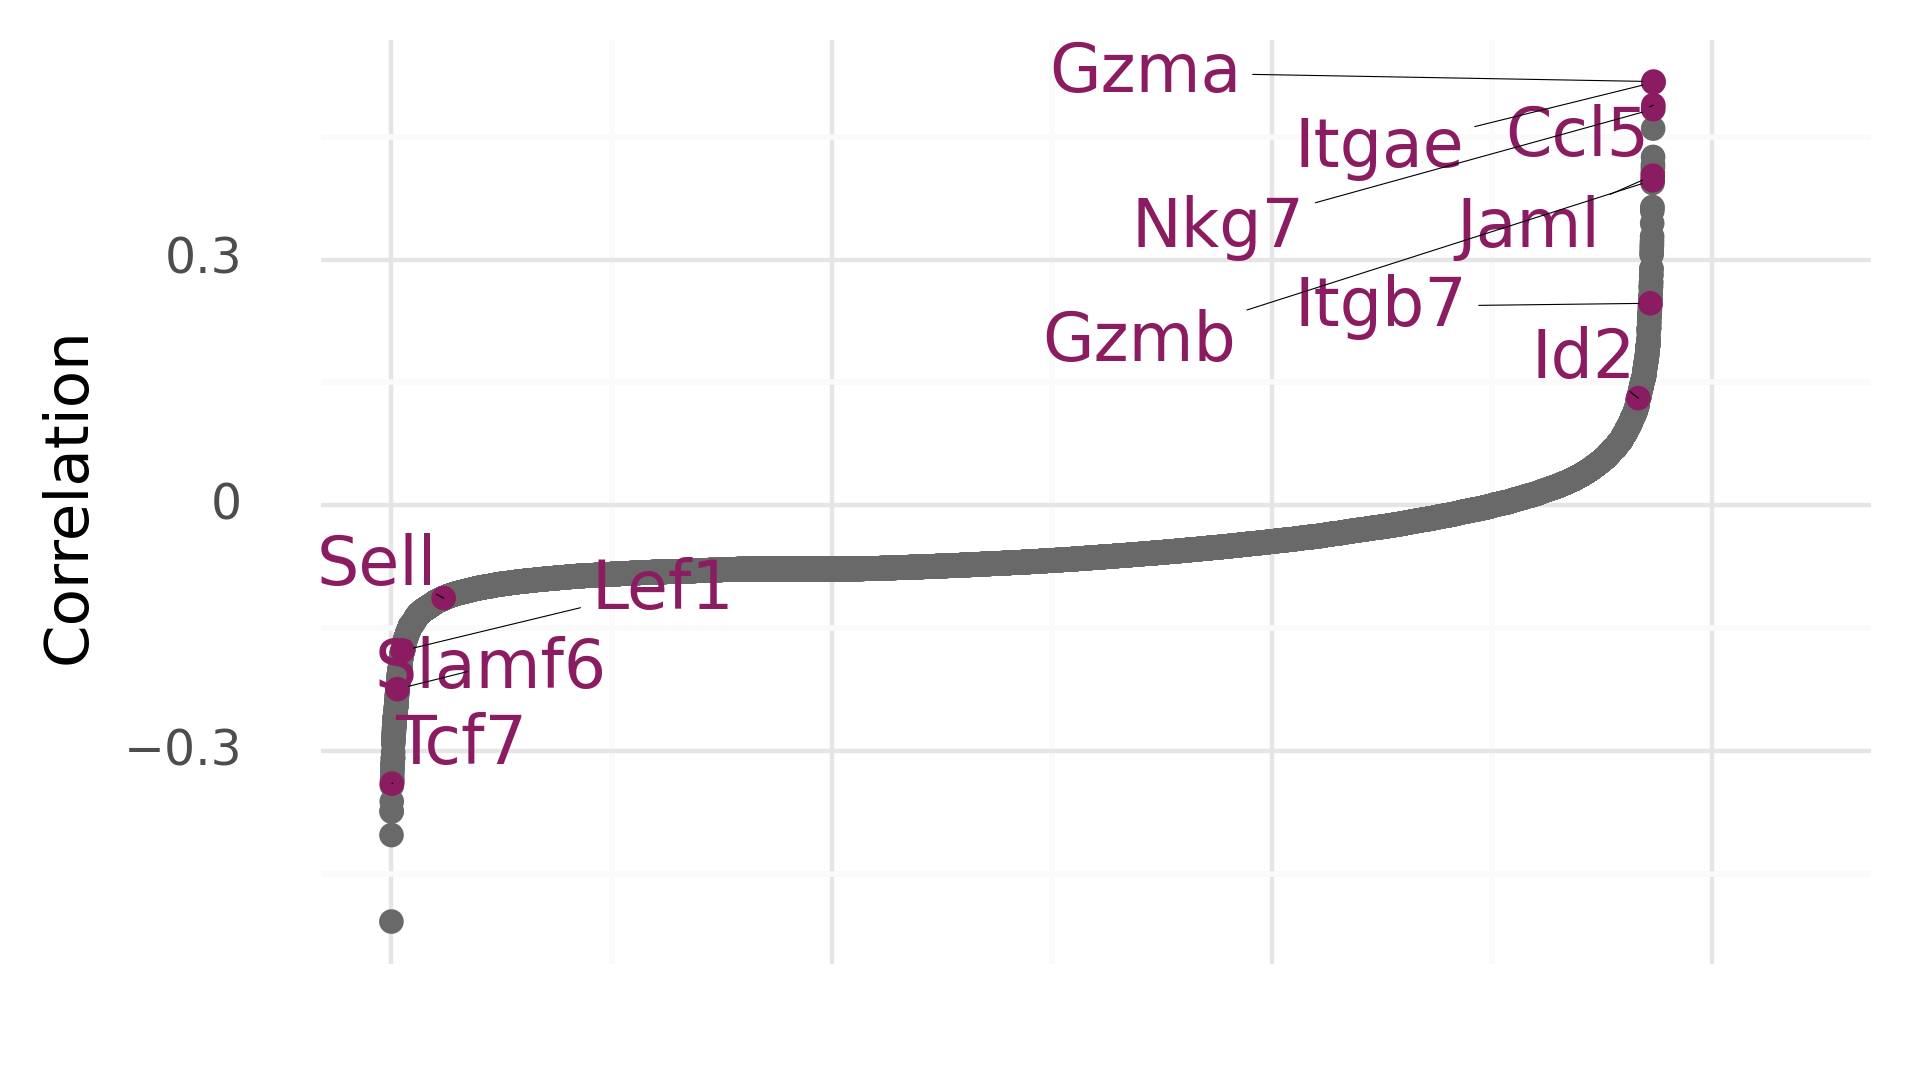

<ggplot: (8791676554737)>

In [78]:
## remove the conventional clusters, do we still see these correlations?
non_conv_spearman_df = make_corr_df(ad[~ad.obs["cd4 annotation"].isin(["Naïve/Tconv", "Tfh-like"])])
p2 = make_corr_plot(non_conv_spearman_df)
p2

In [79]:
ggsave(p2 + ylim(-.6, .7) + theme(figure_size=(4.5,5)), "paper_figures/supplemental/cd4/no_conv_cd4_biotin_corrs.pdf")

/Genomics/grid/users/skwalker/new_scvi/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 4.5 x 5 in image.
/Genomics/grid/users/skwalker/new_scvi/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: paper_figures/supplemental/cd4/no_conv_cd4_biotin_corrs.pdf


## <font color = "navy"> Main figure, 4H

In [80]:
main_cd4_genes = ["Ccl5", "Itgae", "Gzma", "Jaml", "Sell", "Tcf7"]
calc_corr = lambda g: np.round(cd4_spearman_df[cd4_spearman_df["gene"] == g]["corr"].values[0], 3)

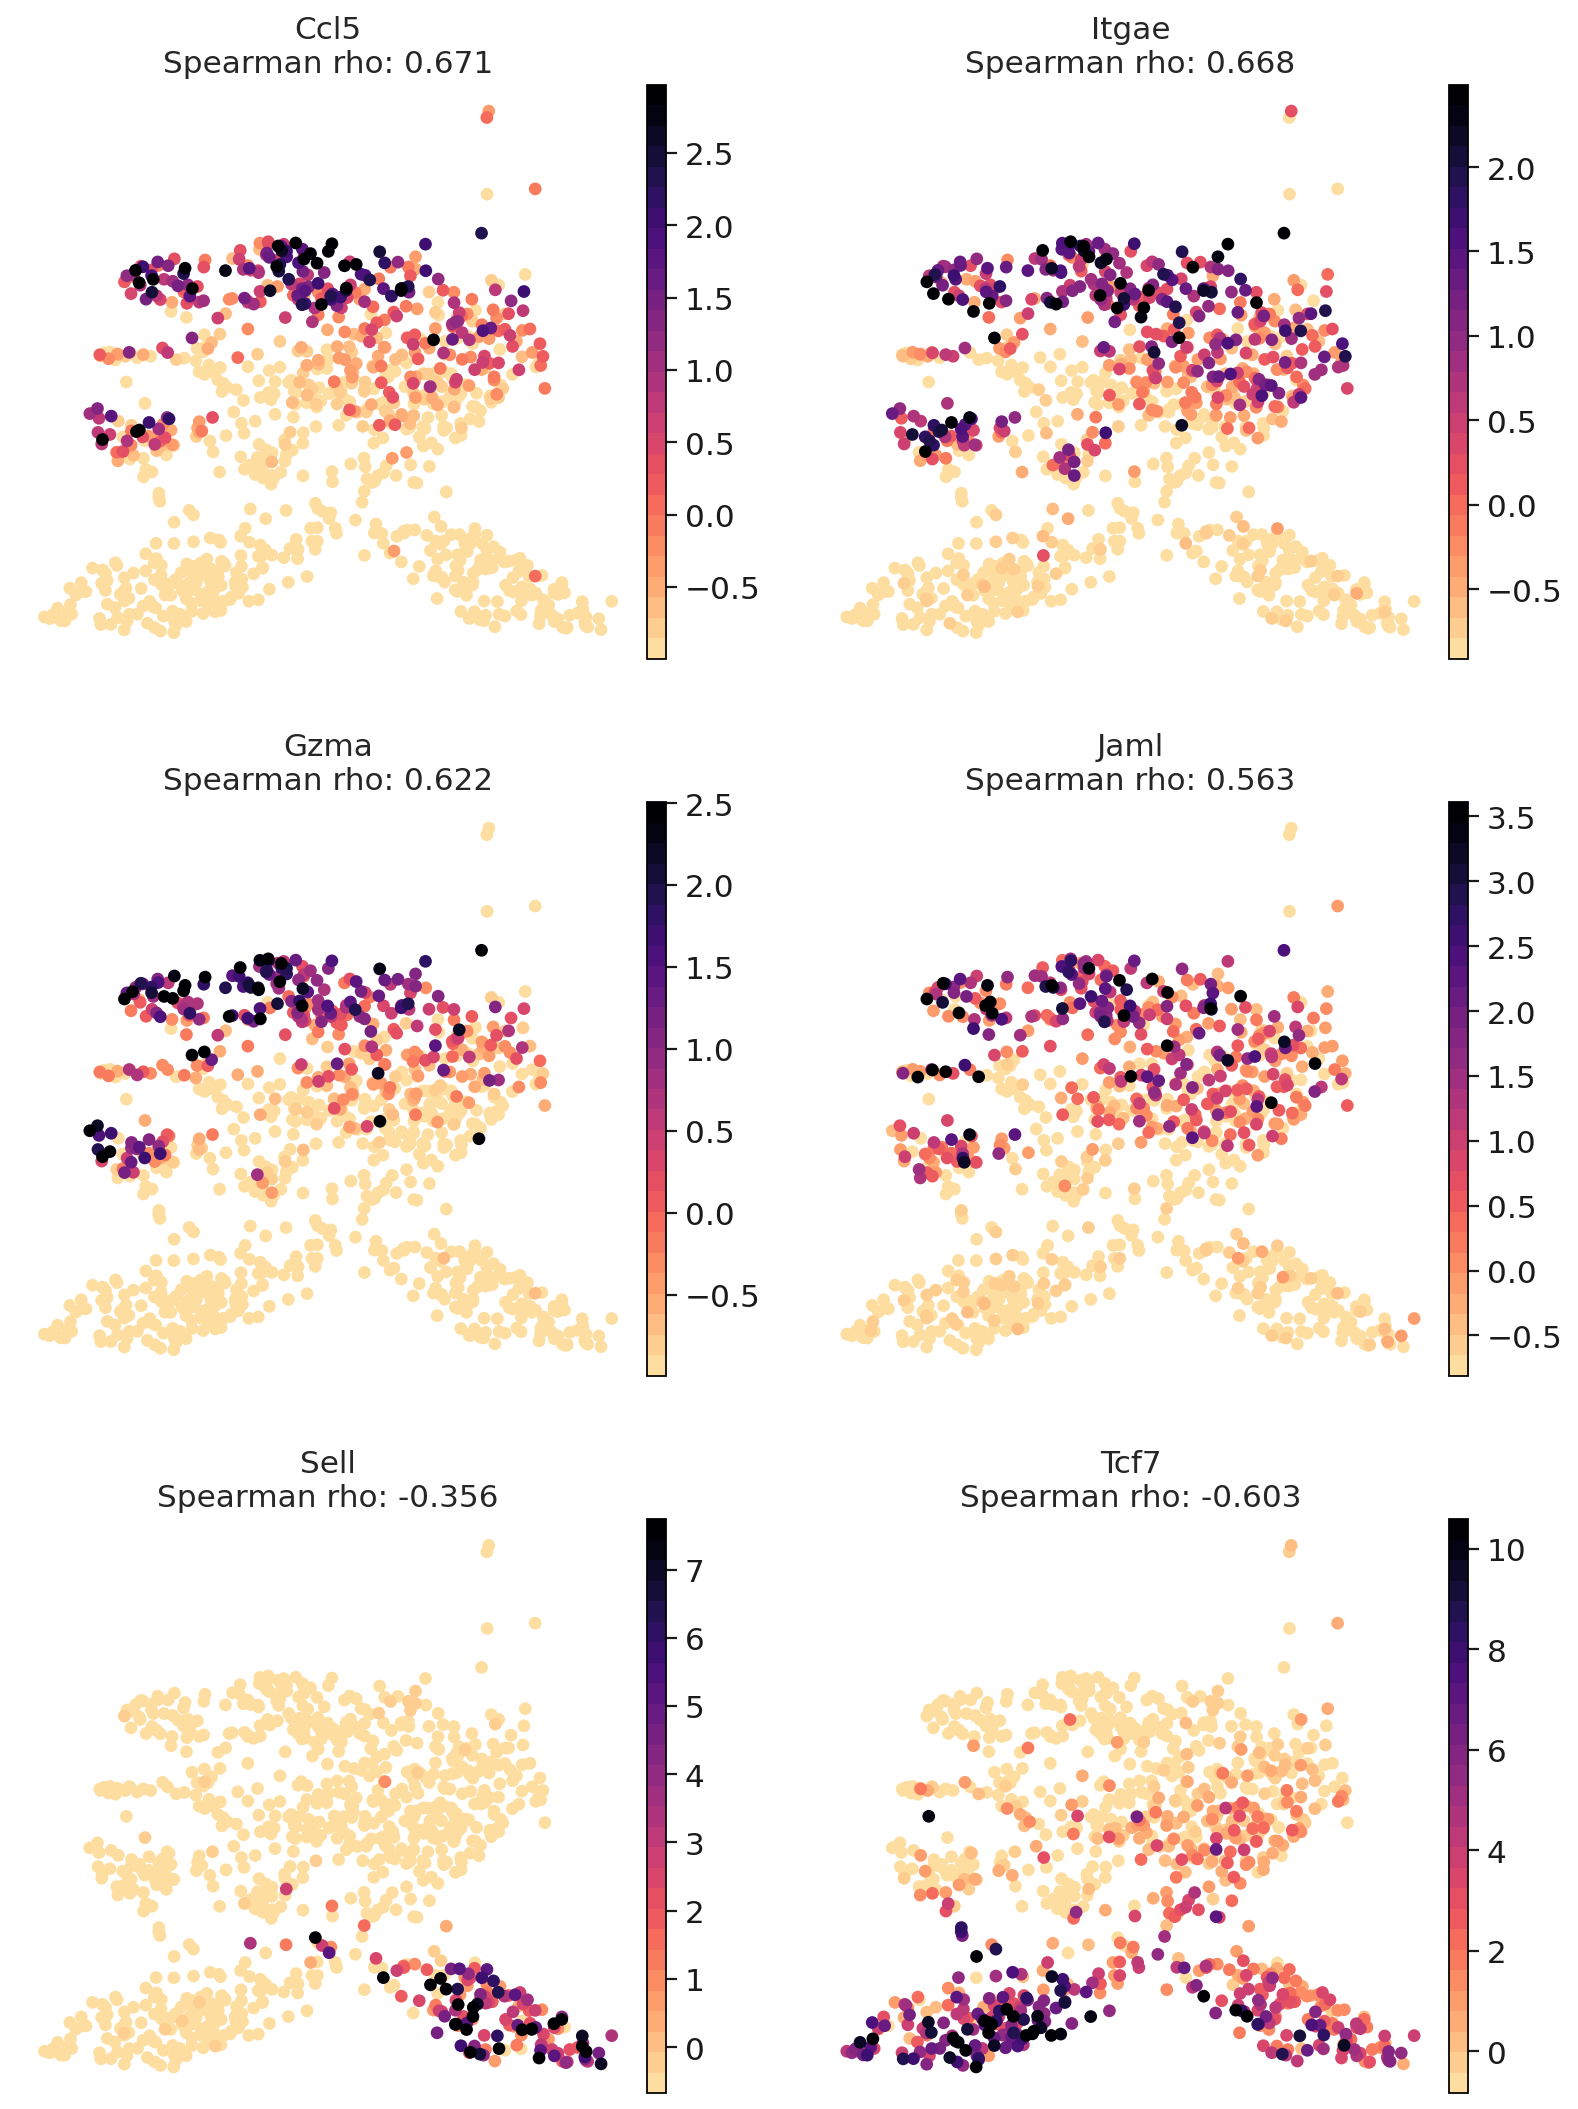

In [81]:
sc.settings.figdir="paper_figures"
sc.set_figure_params(figsize=(5,5), vector_friendly=False)

sc.pl.umap(ad, color = main_cd4_genes, vmin = "p2", vmax="p98", layer = "pearson_theta_1", cmap=magma_cmap,
               title = [ "%s\nSpearman rho: %s"%(g, calc_corr(g)) for g in main_cd4_genes], save="_panel_7.pdf",
          ncols=2, frameon = False)

In [82]:
tcr_ad_obs = ad.obs[["clone_id_size", "normalized biotin"]].dropna()
spearmanr(tcr_ad_obs["normalized biotin"], tcr_ad_obs["clone_id_size"])

SpearmanrResult(correlation=0.5812464368081968, pvalue=5.73432174006444e-78)

## <font color = "navy"> extra Jaml plot, main figure 4I

In [83]:
jaml_iel_ad = sc.read_h5ad("iel_tcr_feb21.h5ad")

In [84]:
jaml_iel_ad = jaml_iel_ad[jaml_iel_ad.obs.annotation.isin(["CD4", "Natural IEL"])]
jaml_iel_ad

View of AnnData object with n_obs × n_vars = 1896 × 14332
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'doublet_score', 'predicted_doublet', 'potential_doublet', 'sample', 'raw_biotin', 'cell_norm_biotin', 'sample_type', 'leiden', 'leiden ', 'log normalized biotin', 'normalized biotin', 'S_score', 'G2M_score', 'phase', 'annotation', 'annotation ', ' leiden ', 'cluster', ' annotation ', 'is_cell', 'high_confidence', 'multi_chain', 'extra_chains', 'IR_VJ_1_c_call', 'IR_VJ_2_c_call', 'IR_VDJ_1_c_call', 'IR_VDJ_2_c_call', 'IR_VJ_1_consensus_count', 'IR_VJ_2_consensus_count', 'IR_VDJ_1_consensus_count', 'IR_VDJ_2_consensus_count', 'IR_VJ_1_d_call', 'IR_VJ_2_d_call', 'IR_VDJ_1_d_call', 'IR_VDJ_2_d_call', 'IR_VJ_1_duplicate_count', 'IR_VJ_2_duplicate_count', 'IR_VDJ_1_duplicate_count', 'IR_VDJ_2_duplicate_count', 'IR_VJ_1_j_call', 'IR_VJ_2_j_call', 'IR_VDJ_1_j_call', 'IR_VDJ_2_j_call', 'IR_VJ_1_junction', 'IR_VJ_2_junction', 'IR_VDJ_1_junction',

In [85]:
def get_iel_cell_type(has_tcr, cell):
    if cell in ad.obs_names:
        return ad.obs.loc[cell]["cd4 annotation"]
    if has_tcr == "True":
        return "CD8 IEL"
    if jaml_iel_ad[cell, "Trdc"].layers["pearson_theta_1"] > 0:
        return "GD IEL"
jaml_iel_ad.obs["cell type"] = [ get_iel_cell_type(row["has_ir"], cell) for cell, row in jaml_iel_ad.obs.iterrows()]

/tmp/ipykernel_102559/2062703311.py:8: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


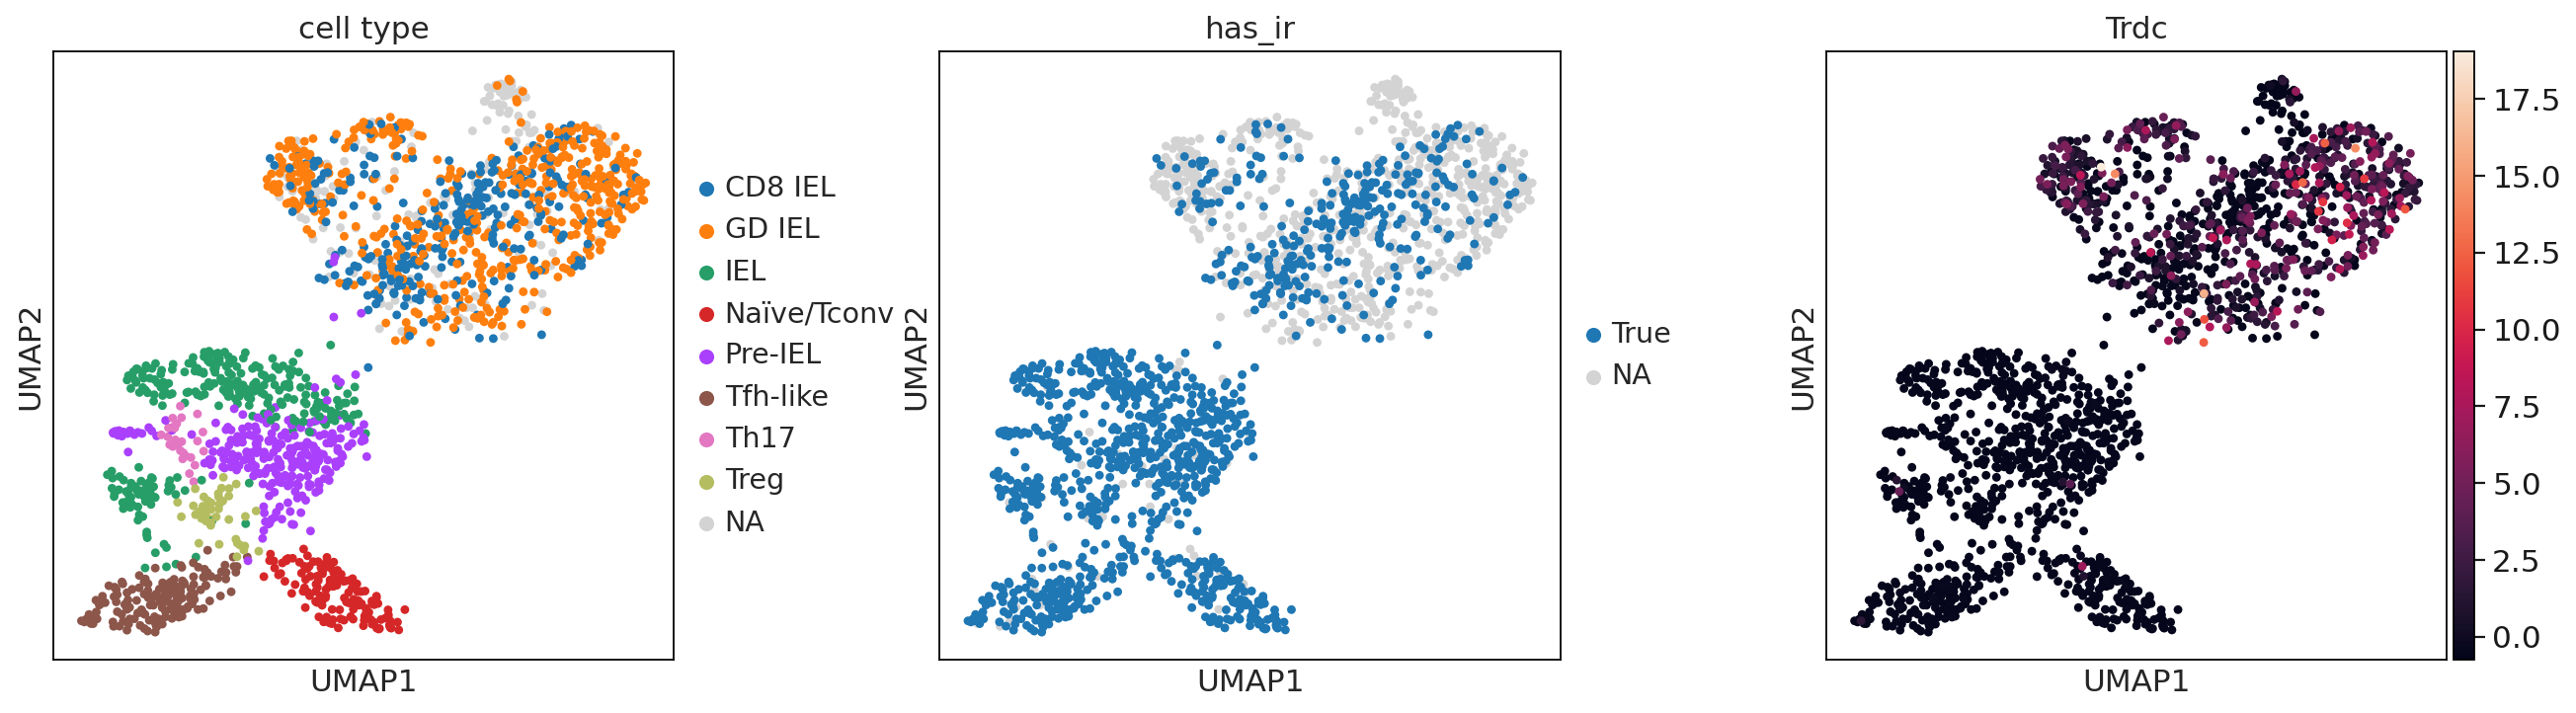

In [86]:
sc.pl.umap(jaml_iel_ad, color = ["cell type", "has_ir", "Trdc"], layer = "pearson_theta_1", wspace = 0.3)

In [87]:
np.sum(jaml_iel_ad.obs["cell type"].isna())

163

In [88]:
jaml_iel_ad.obs.groupby("cell type").count()

n_genes  n_genes_by_counts  total_counts  total_counts_mt  \
cell type                                                                
CD8 IEL          301                301           301              301   
GD IEL           517                517           517              517   
IEL              285                285           285              285   
Naïve/Tconv      136                136           136              136   
Pre-IEL          265                265           265              265   
Tfh-like         161                161           161              161   
Th17              26                 26            26               26   
Treg              42                 42            42               42   

             pct_counts_mt  doublet_score  predicted_doublet  \
cell type                                                      
CD8 IEL                301            301                301   
GD IEL                 517            517                517   
IEL                    285            285                285   
Naïve/Tconv            136            136                136   
Pre-IEL                265            265                265   
Tfh-like               161            161                161   
Th17                    26             26                 26   
Treg                    42             42                 42   

             potential_doublet  sample  raw_biotin  ...  IR_VJ_1_v_call  \
cell type                                           ...                   
CD8 IEL                    301     301         301  ...             240   
GD IEL                     517     517         517  ...               0   
IEL                        285     285         285  ...             259   
Naïve/Tconv                136     136         136  ...             119   
Pre-IEL                    265     265         265  ...             238   
Tfh-like                   161     161         161  ...             142   
Th17                        26      26          26  ...              24   
Treg                        42      42          42  ...              36   

             IR_VJ_2_v_call  IR_VDJ_1_v_call  IR_VDJ_2_v_call  has_ir  \
cell type                                                               
CD8 IEL                  26              297                8     301   
GD IEL                    0                0                0       0   
IEL                      14              271                4     274   
Naïve/Tconv              15              120                2     124   
Pre-IEL                  24              236                6     244   
Tfh-like                 23              143                3     145   
Th17                      2               23                1      24   
Treg                      9               38                2      39   

             receptor_type  receptor_subtype  chain_pairing  clone_id  \
cell type                                                               
CD8 IEL                301               301            301       301   
GD IEL                   0                 0              0         0   
IEL                    274               274            274       274   
Naïve/Tconv            124               124            124       124   
Pre-IEL                244               244            244       244   
Tfh-like               145               145            145       145   
Th17                    24                24             24        24   
Treg                    39                39             39        39   

             clone_id_size  
cell type                   
CD8 IEL                301  
GD IEL                   0  
IEL                    274  
Naïve/Tconv            124  
Pre-IEL                244  
Tfh-like               145  
Th17                    24  
Treg                    39  

[8 rows x 74 columns]

In [89]:
jaml_iel_ad = jaml_iel_ad[jaml_iel_ad.obs["cell type"].isin(["Naïve/Tconv", "Pre-IEL", "IEL", "CD8 IEL", "GD IEL"])]

In [90]:
jaml_df = pd.DataFrame({"cell_type": jaml_iel_ad.obs["cell type"],
                       "Jaml": np.array(jaml_iel_ad[:, "Jaml"].layers["pearson_theta_1"]).flatten()})

jaml_df.head()

cell_type      Jaml
AAACCTGTCGGCCGAT-1    GD IEL  1.330718
AAACGGGAGGTGCAAC-1    GD IEL  0.647444
AAACGGGCAGTATAAG-1    GD IEL  0.239438
AAACGGGCATCAGTCA-1   CD8 IEL -0.107477
AAACGGGGTCTGGTCG-1       IEL -0.692543

In [91]:
jaml_df["cell_type"] = jaml_df["cell_type"].astype(CategoricalDtype(
    categories=["Naïve/Tconv", "Pre-IEL", "IEL", "CD8 IEL", "GD IEL"], ordered = True))


In [92]:
jaml_df["Jaml"] = jaml_df["Jaml"] - np.min(jaml_df["Jaml"])

In [93]:
jaml_violin_v2 = ggplot(jaml_df, aes(x ="cell_type", y="Jaml", fill = "cell_type")) + geom_violin(alpha = 0.7) + \
theme_minimal() + theme(figure_size=(6, 3)) + geom_jitter(
    color="black", size = 0.01, width=0.1) +  coord_cartesian(
    ylim = (np.log10(np.quantile(jaml_df["Jaml"], 0.05)), np.log10(np.max(jaml_df["Jaml"])))) + scale_y_log10() 

## <font color = "navy"> Figure 4, Panel I (right)

/Genomics/grid/users/skwalker/new_scvi/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
/Genomics/grid/users/skwalker/new_scvi/lib/python3.9/site-packages/plotnine/layer.py:334: PlotnineWarning: stat_ydensity : Removed 1 rows containing non-finite values.


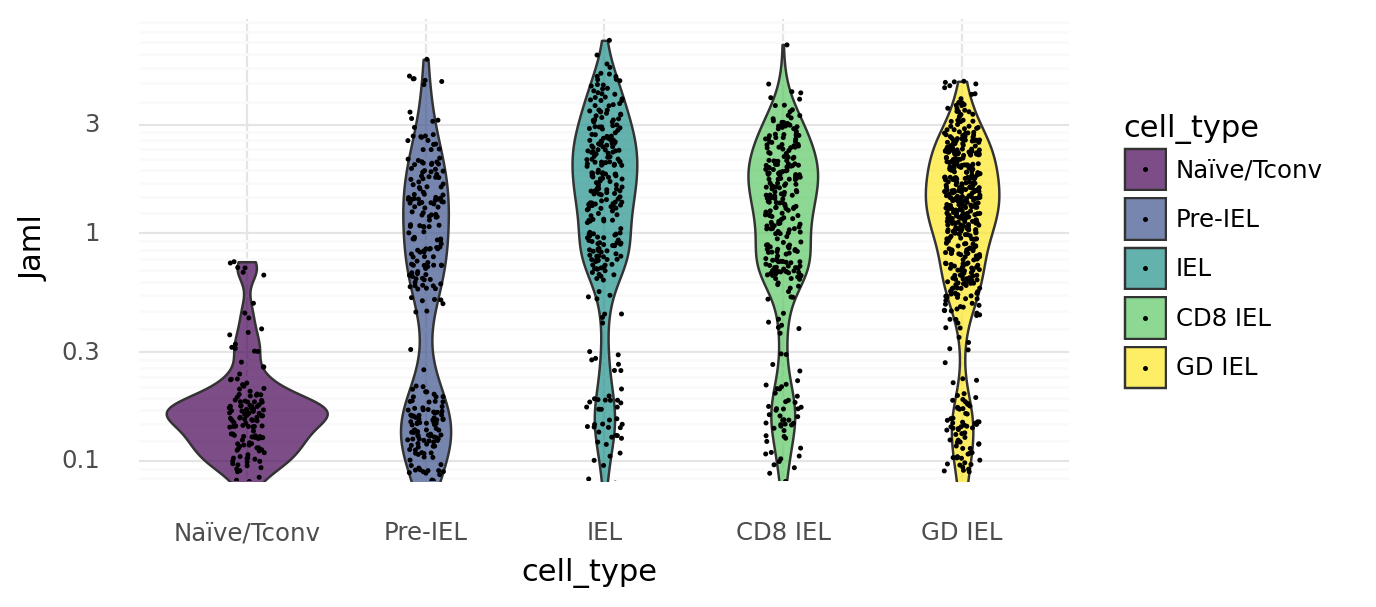

<ggplot: (8791739240319)>

In [94]:
jaml_violin_v2

In [95]:
ggsave(jaml_violin_v2, "paper_figures/violin_jaml.panel_i.final.pdf")

/Genomics/grid/users/skwalker/new_scvi/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6 x 3 in image.
/Genomics/grid/users/skwalker/new_scvi/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: paper_figures/violin_jaml.panel_i.final.pdf
/Genomics/grid/users/skwalker/new_scvi/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
/Genomics/grid/users/skwalker/new_scvi/lib/python3.9/site-packages/plotnine/layer.py:334: PlotnineWarning: stat_ydensity : Removed 1 rows containing non-finite values.


In [96]:
ad.write_h5ad("cd4_iel.h5ad")